# Úkol č. 3 - Segmentace zákazníků e-shopu (do 7. ledna)

Jednou z důležitých aplikací shlukování je **segmentace zákazníků** (angl. **customer segmentation**). 

Předpokládejme, že máme následující obchodní údaje o prodejích (resp. nákupech z pohledu zákazníků):
TransactionID - ID nákupu,
CustomerID - ID zákazníka, 
Date - datum nákupu, 
Total - celková cena nákupu.

Chceme najít segmenty zákazníků, kteří se chovají podobně. K tomu je dobré informace z jednotlivých nákupů pro individuální zákazníky agregovat. Tj. získat pro každého zákazníka jeden řádek.

Populárním přístupem je **RFM**, což znamená:

- **R**ecency: Počet dnů od posledního nákupu (poslední datum v datasetu pro daného zákazníka)
- **F**requency: Počet nákupů. Občas se vynechávají zákazníci s jediným nákupem. Pro jednoduchost je zde ale necháme.
- **M**onetary: Celková suma, kterou daný zákazník utratil.

## Zdroj dat
Budeme pracovat s daty z jednoho (skoro) vymyšleného eshopu:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("eshop.csv")

## Pokyny k vypracování

**Základní body zadání**, za jejichž (poctivé) vypracování získáte **8 bodů**:
- Vytvořte `rfm` data frame, kde každý řádek odpovídá jednomu zákazníkovi a sloupce (příznaky) jsou uvedené výše. **[OK]**


- Pomocí algoritmu `K-means` proveďte shlukování. Nějakým způsobem také odhadněte nejlepší počet shluků (podrobně vysvětlete).


- Zabývejte se vlivem přeškálování dat (standardizace příznaků). Tj. určete, zda je přeškálování vhodné, a proveďte ho.


- Interpretujte jednotlivé shluky. Použijte získané shluky k odlišení
    -  "superstar" zákazníků (vysoká monetary, vysoká frequency a nízká recency) od 
    - nezajímavých  zákazníků (vysoká recency, nízká frequency, nízká monetary).

**Další body zadání** za případné další body  (můžete si vybrat, maximum bodů za úkol je každopádně 12 bodů):
- (až +4 body) Proveďte analýzu vytvořených shluků pomocí metody silhouette (https://en.wikipedia.org/wiki/Silhouette_(clustering)).
- (až +4 body) Zkuste provést to samé s modifikovanou verzí **RFM**, kde Recency = "maximum počtu měsíců od posledního nákupu a čísla 1", Frequency = "maximum počtu nákupů daného zákazníka v posledních 12 měsících a čísla 1", Monetary = "Nejvyšší hodnota nákupu daného zákazníka". Porovnejte s původním přístupem.

# 1. Create rfm_basic (...basic like basic version...)

- **R**ecency: Počet dnů od posledního nákupu (poslední datum v datasetu pro daného zákazníka)
- **F**requency: Počet nákupů. Občas se vynechávají zákazníci s jediným nákupem. Pro jednoduchost je zde ale necháme.
- **M**onetary: Celková suma, kterou daný zákazník utratil.

In [3]:
now = pd.Timestamp.now().to_datetime64()

In [4]:
df_agg = df.groupby('Customer ID').agg({'Date':['max', 'count'], 'Subtotal':'sum'})
df_agg['Recency'] = ( now - df_agg.Date['max'].astype('datetime64[ns]') ).astype('timedelta64[D]')
df_agg['Frequency'] = df_agg.Date['count']
df_agg['Monetary'] = df_agg.Subtotal['sum']
rfm_basic = df_agg[['Recency', 'Frequency', 'Monetary']].copy()
rfm_basic.head()

Recency Frequency Monetary
                                      
Customer ID                           
7            2125.0         3    15.54
9            4164.0         1    13.20
30           4139.0         1    36.20
34           4217.0         1    86.00
38           4211.0         1    38.40

* Lets try to visualise the data, maybe we would allready see some clusters
* First prepare some nice methods

In [338]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
from matplotlib import cm
import itertools

def plot_it_3d(data, data_name):
    perms = list(itertools.permutations(['Recency', 'Frequency','Monetary']))
    i = 1
    fig = plt.figure(figsize=(25,25))       # set dimensions of the figure
    for p in perms:
        fig.suptitle('3D plot of '+data_name+' - from all different directions', fontsize=30)
        ax = fig.add_subplot(3,3, i, projection='3d')
        ax.scatter(data[p[0]], data[p[1]], data[p[2]], c=data[p[1]])
        ax.set_xlabel(p[0])
        ax.set_ylabel(p[1])
        ax.set_zlabel(p[2])
        i +=1
    plt.show()

def plot_it_2d(data, data_name):    
    # and also 2d projections
    combs = list(itertools.combinations(['Recency', 'Frequency','Monetary'], 2))
    i = 1
    fig = plt.figure(figsize=(25,8))       # set dimensions of the figure
    for p in combs:
        fig.suptitle('plot of '+data_name+', 3rd axes is represented by color', fontsize=30)
        plt.subplot(1,3, i)
        # get colors based on unplottted value
        lst = ['Recency', 'Frequency','Monetary']
        a = [h for h,x in enumerate(lst) if x == p[0]]
        b = [h for h,x in enumerate(lst) if x == p[1]]
        if a[0]+b[0] == 1:
            col_name = 'Monetary'
        elif a[0]+b[0] == 2:
            col_name = 'Frequency'
        else:
            col_name = 'Recency'

        plt.scatter(data[p[0]], data[p[1]], c=data[col_name])
        plt.xlabel(p[0])
        plt.ylabel(p[1])
        plt.legend([col_name])

        i +=1
    plt.show()


* and lets do the plotting

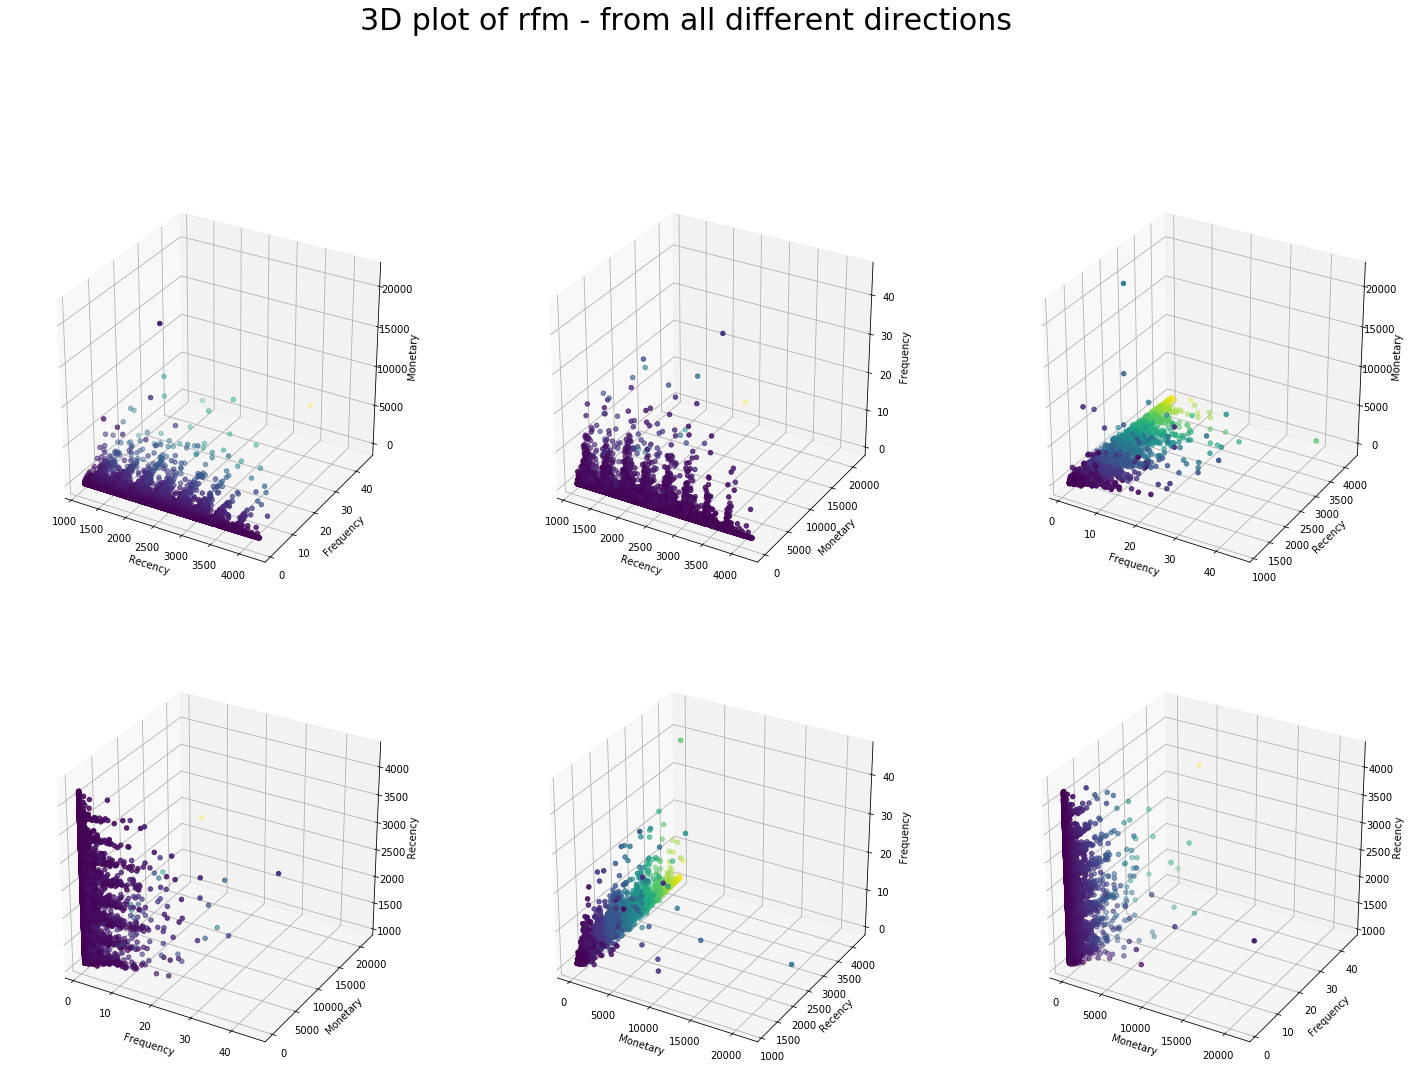

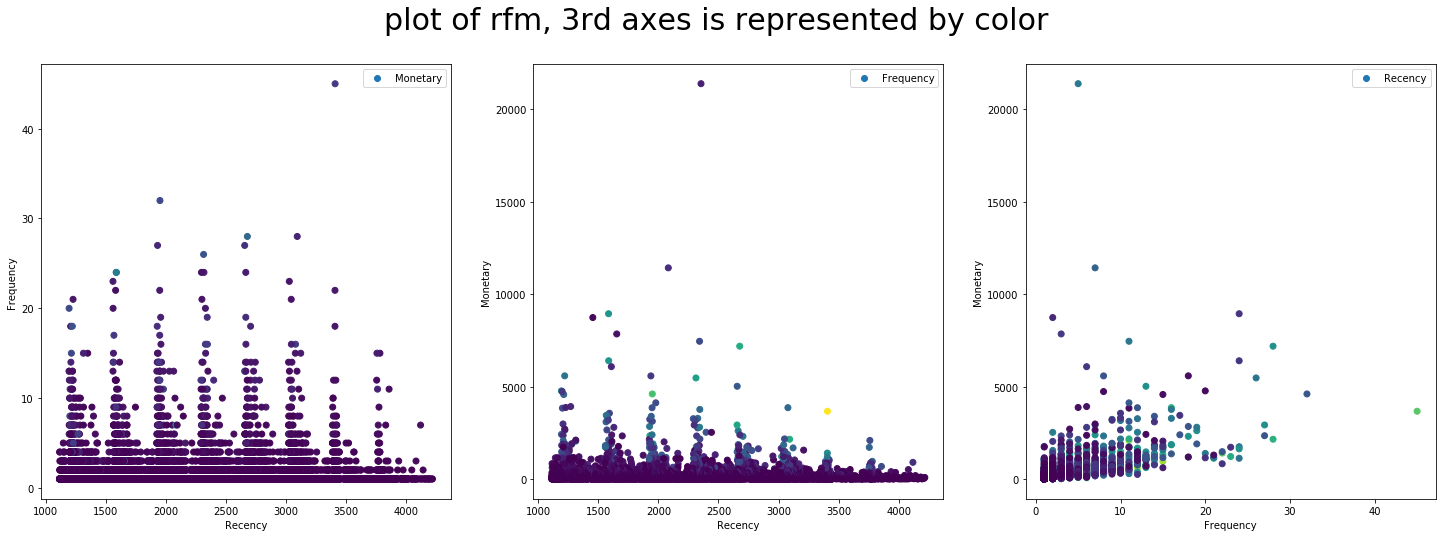

In [339]:
plot_it_3d(rfm_basic, 'rfm')
plot_it_2d(rfm_basic, 'rfm')

##### Result:
* We can allready see that:
    * there is a big chunk of not interesting customers
    * There are bunch of outliers like: someone who spent hell of a lot money
    * there is some strange corelation where customers who spent lot of money/shopped frequently stopped in similiar parts of the year (i guess it would be holiday, but it's kind of unneccesary for us..)
* Right away I would propose to delete all those outliers because it can affect our clustering...
* But for now, I'll leave it and delete it later

* There are three most common methods of determining optimal number of clusters
    * Elbow method
    * Silhouette method
    * Gap statistic method
* We'll try all three of them

## 1.1 Elbow method
* we calculate intra-cluster variation for various number of clusters
* basic idea: when adding N th more cluster won't significantly improve (minimize) variance, then it's better to stick with N-1 th number of clusters

In [84]:
import warnings
warnings.filterwarnings('ignore')

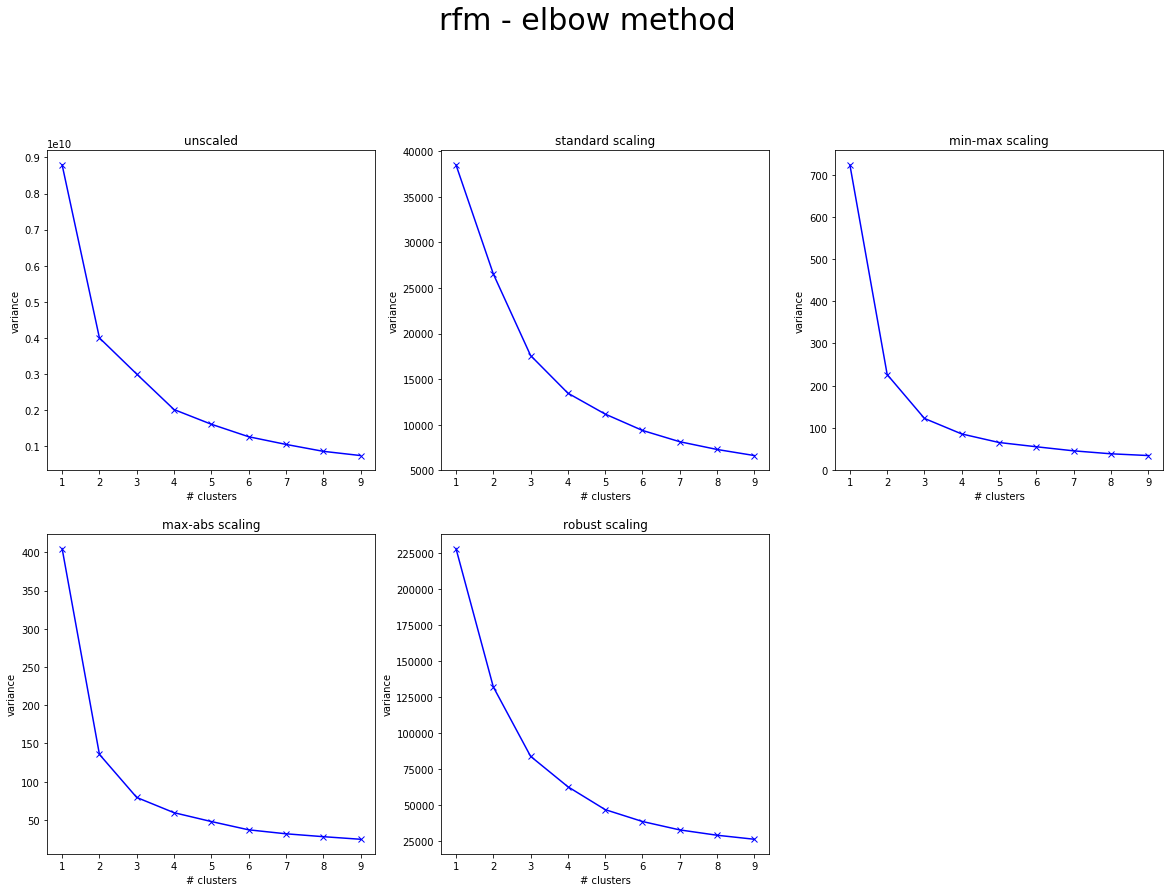

In [371]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, PowerTransformer, QuantileTransformer, Normalizer
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist


def scale_data(data):
    distributions =  [('unscaled', data.values),
    ('standard scaling', StandardScaler().fit_transform(data)),
    ('min-max scaling',  MinMaxScaler().fit_transform(data)),
    ('max-abs scaling',  MaxAbsScaler().fit_transform(data)),
    ('robust scaling', RobustScaler(quantile_range=(25, 75)).fit_transform(data))]
    
    # PLOT SCALED DATA
    #i = 1
    #fig = plt.figure(figsize=(25,25))       # set dimensions of the figure
    #fig.suptitle('3d plot of scaled data', fontsize=30)
    #for distrib in distributions:
    #    title, X = distrib
    #    ax = fig.add_subplot(3,3, i, projection='3d')
    #    ax.scatter(X[:, 1], X[:, 0],X[:, 2], c=X[:, 0])
    #    ax.set_xlabel('Frequency')
    #    ax.set_ylabel('Recency')
    #    ax.set_zlabel('Monetary')
    #    ax.set_title(title)
    #    i +=1
    #plt.show()
    
    return distributions

def plot_elbow_method(distributions, fig_title):
    
    # PLOT ELBOW METHOD
    i = 1
    fig = plt.figure(figsize=(20,20))       # set dimensions of the figure
    fig.suptitle(fig_title, fontsize=30)

    for distrib in distributions:
        title, X = distrib
    
        # KMEANS
        # try different number of clusters && measure distoritons
        cost = []
        rang = range(1,10)
        for k in rang:
            km = KMeans(n_clusters=k)
            km.fit(X)
            # calculate average of squared distances between samples and its closest cluster centers
            # aka. calculate var X
            #cost.append(np.average(pow(np.min(cdist(X, km.cluster_centers_, 'euclidean'), axis=1), 2)))
            cost.append(km.inertia_)
        # Plot result
        ax = fig.add_subplot(3,3, i)
        ax.plot(rang, cost, 'bx-')
        #plt.plot(rang, cost, 'bx-')
        ax.set_xlabel('# clusters')
        ax.set_ylabel('variance')
        ax.set_title(title)
        i += 1
    plt.show()

distributions = scale_data(rfm_basic)    
plot_elbow_method(distributions, "rfm - elbow method")

##### Result:
    * Ok we -see from elbow method that the ideal number of clusters is most probably between 3 and 6
    * lets now try Silhouette method

## 1.2 Avg silhouette method

* We compute average (expected value) silhoulette of all point within each cluster for various number of clusters
    * silhoulette is computed as s(i) = ( other(i)  - same(i) ) / max{other(i), same(i)}
    * where same(i) means avg. distance between all data from same cluster as i
    * and other(i) is minimum from averages of distances between i and points from all other clusters
* We are trying to find maximum of those values
* That value will mean qualit of the clustering

In [299]:
from sklearn.metrics import silhouette_samples, silhouette_score

# disclaimer: about 35% of this method is from scikit-learn.org tuturial !
def plot_avg_silhouette_method(data, data_title, a=3, b=7):
        
    results_to_plot = {}

    for distrib in data:
        
        title, X = distrib
        fig_title = data_title + " - avg_silhouette method - distribution = "  + title
        
        # we are using our aproximation 3 - 6 clusters
        range_n_clusters = range(a,b)
        j = 1
        fig = plt.figure(figsize=(20,14))       # set dimensions of the figure
        fig.suptitle(fig_title, fontsize=20)
        results_y = []
        results_x = []
        for n_clusters in range_n_clusters:
            # Create a subplot with 1 row and 2 columns
            ax1 = plt.subplot(2,len(range_n_clusters),j)
            ax2 = fig.add_subplot(2, len(range_n_clusters), j + len(range_n_clusters), projection='3d')

            j+=1
            
            # The 1st subplot is the silhouette plot
            ax1.set_xlim([-0.1, 1])
            # plots of individual clusters, to demarcate them clearly.
            ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

            # Initialize the clusterer with n_clusters value and a random generator
            # seed of 10 for reproducibility.
            clusterer = KMeans(n_clusters=n_clusters, random_state=10)
            cluster_labels = clusterer.fit_predict(X)

            # The silhouette_score gives the average value for all the samples.
            # This gives a perspective into the density and separation of the formed
            # clusters
            silhouette_avg = silhouette_score(X, cluster_labels)
            results_y.append(silhouette_avg)
            results_x.append(n_clusters)
            
            # Compute the silhouette scores for each sample
            sample_silhouette_values = silhouette_samples(X, cluster_labels)
            y_lower = 10
            for i in range(n_clusters):
                # Aggregate the silhouette scores for samples belonging to
                # cluster i, and sort them
                ith_cluster_silhouette_values = \
                    sample_silhouette_values[cluster_labels == i]

                ith_cluster_silhouette_values.sort()

                size_cluster_i = ith_cluster_silhouette_values.shape[0]
                y_upper = y_lower + size_cluster_i

                color = cm.nipy_spectral(float(i) / n_clusters)
                ax1.fill_betweenx(np.arange(y_lower, y_upper),
                                  0, ith_cluster_silhouette_values,
                                  facecolor=color, edgecolor=color, alpha=0.7)

                # Label the silhouette plots with their cluster numbers at the middle
                ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
                # Compute the new y_lower for next plot
                y_lower = y_upper + 10  # 10 for the 0 samples

            ax1.set_title("Avg silhouette plot, k = {}".format(n_clusters))
            ax1.set_xlabel("The silhouette coefficient values")
            ax1.set_ylabel("Cluster label")

            # The vertical line for average silhouette score of all the values
            ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

            ax1.set_yticks([])  # Clear the yaxis labels / ticks
            ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])        

            # Visualise clusters
            colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
            ax2.scatter(X[:, 1], X[:, 0],X[:, 2] , marker='.', s=30, lw=0, alpha=0.7,
                        c=colors, edgecolor='k', )

            ax2.set_title("Clusters 3d plot, k = {}".format(n_clusters))
            ax2.set_xlabel('Frequency')
            ax2.set_ylabel('Recency')
            ax2.set_zlabel('Monetary')

        plt.show()
        results_to_plot[title] = (results_x, results_y)
    return results_to_plot

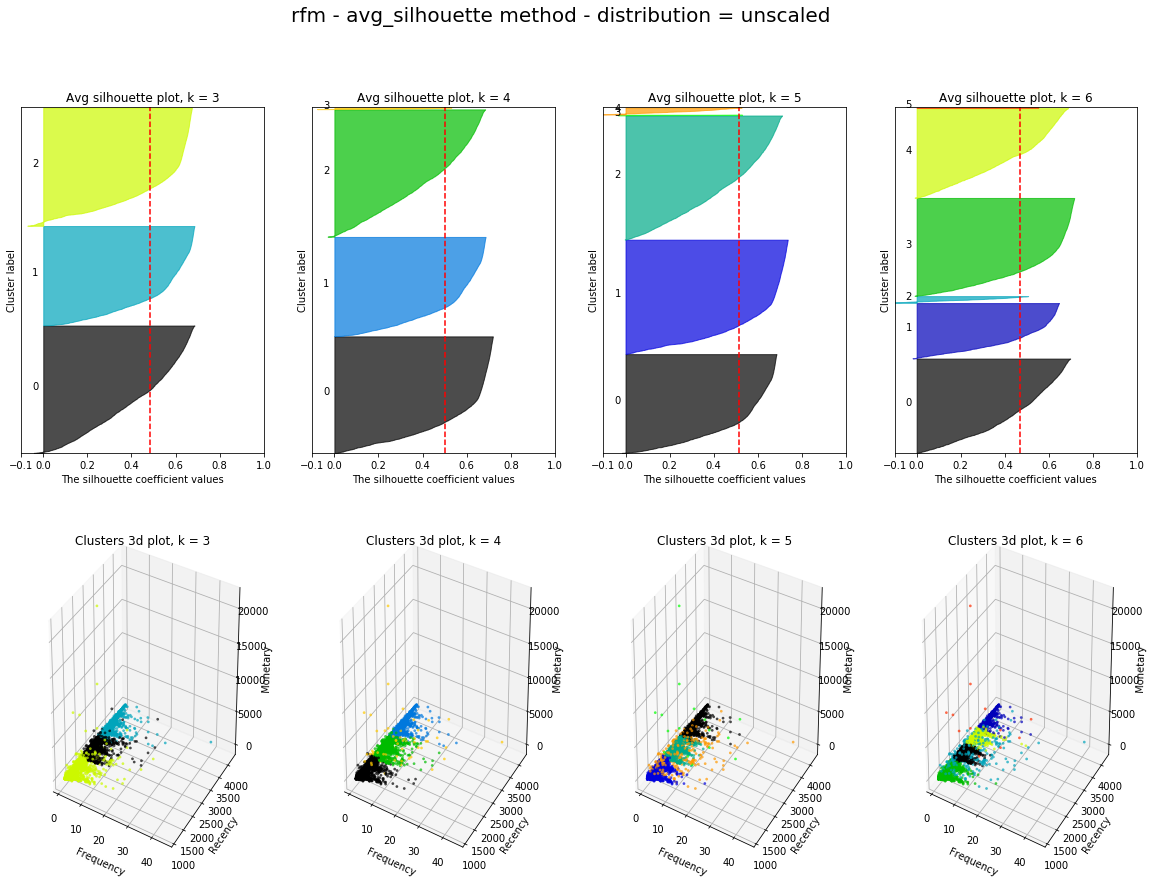

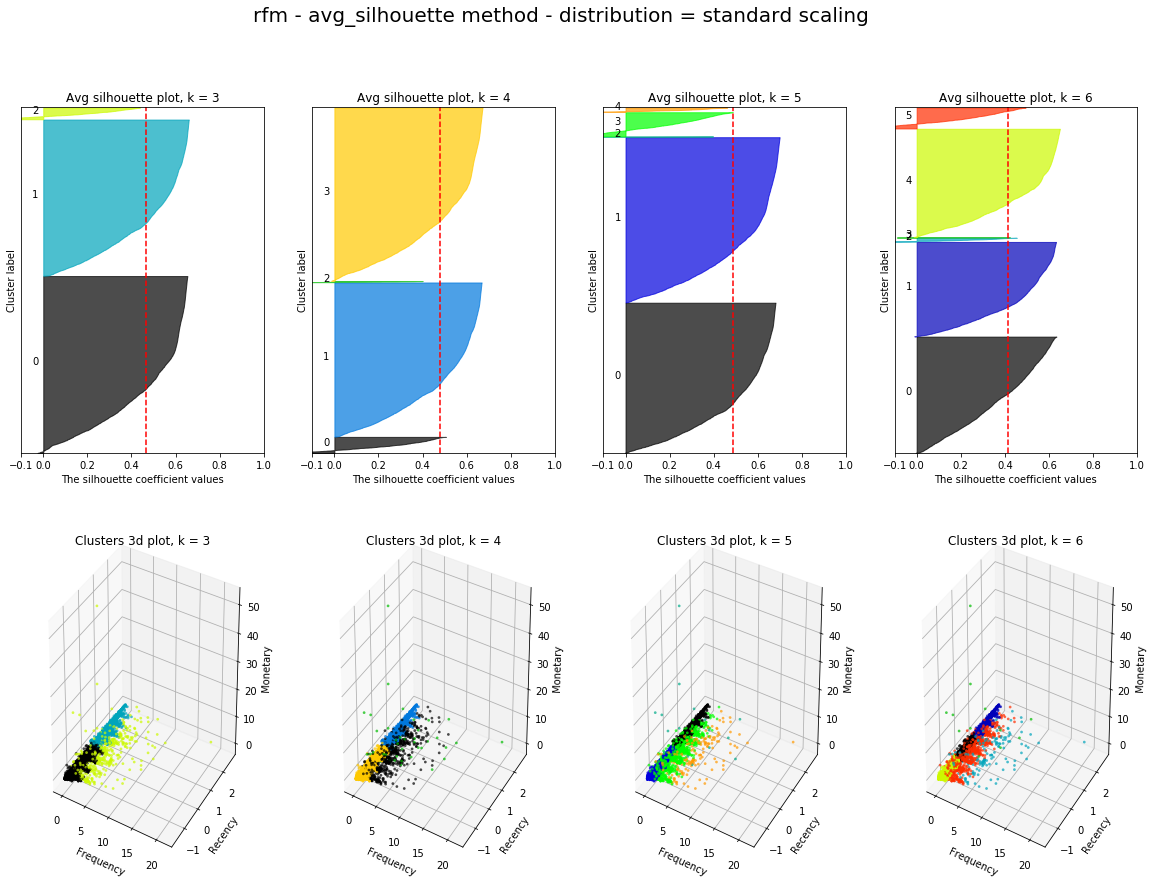

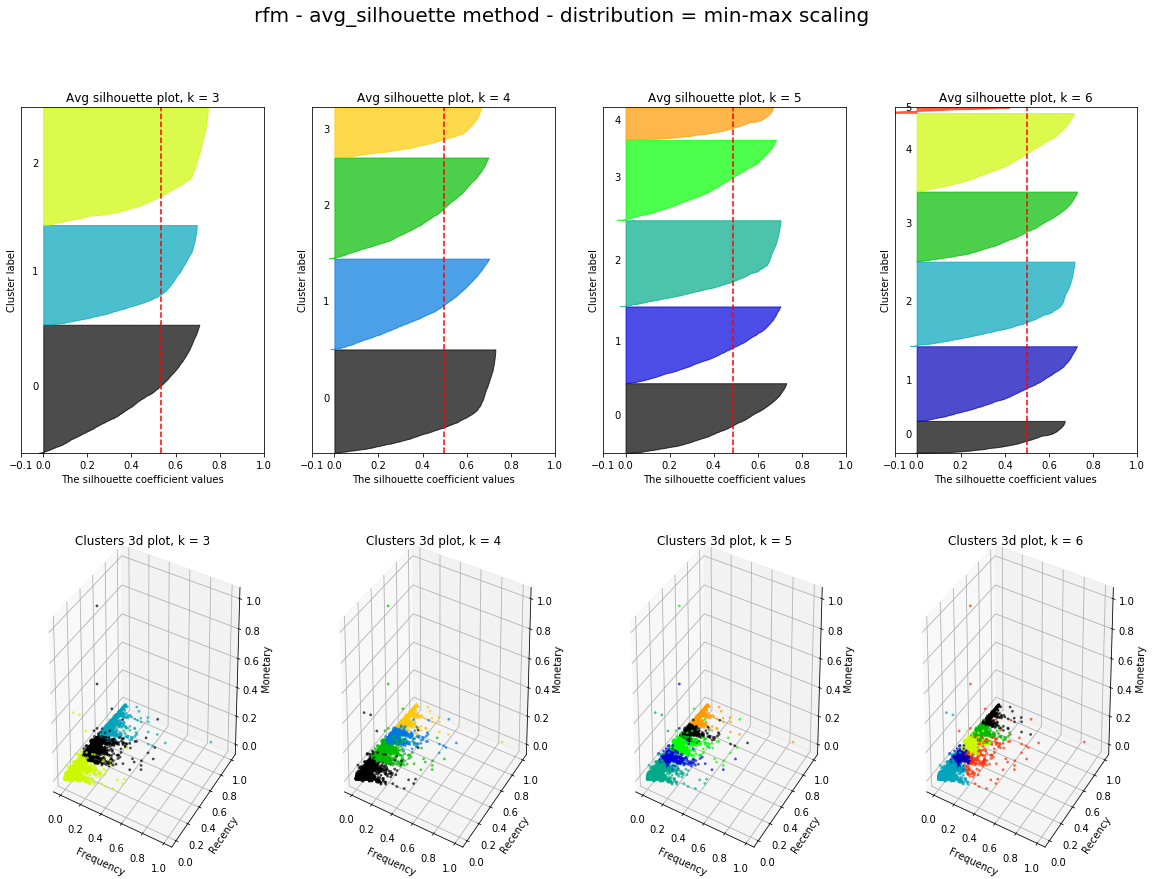

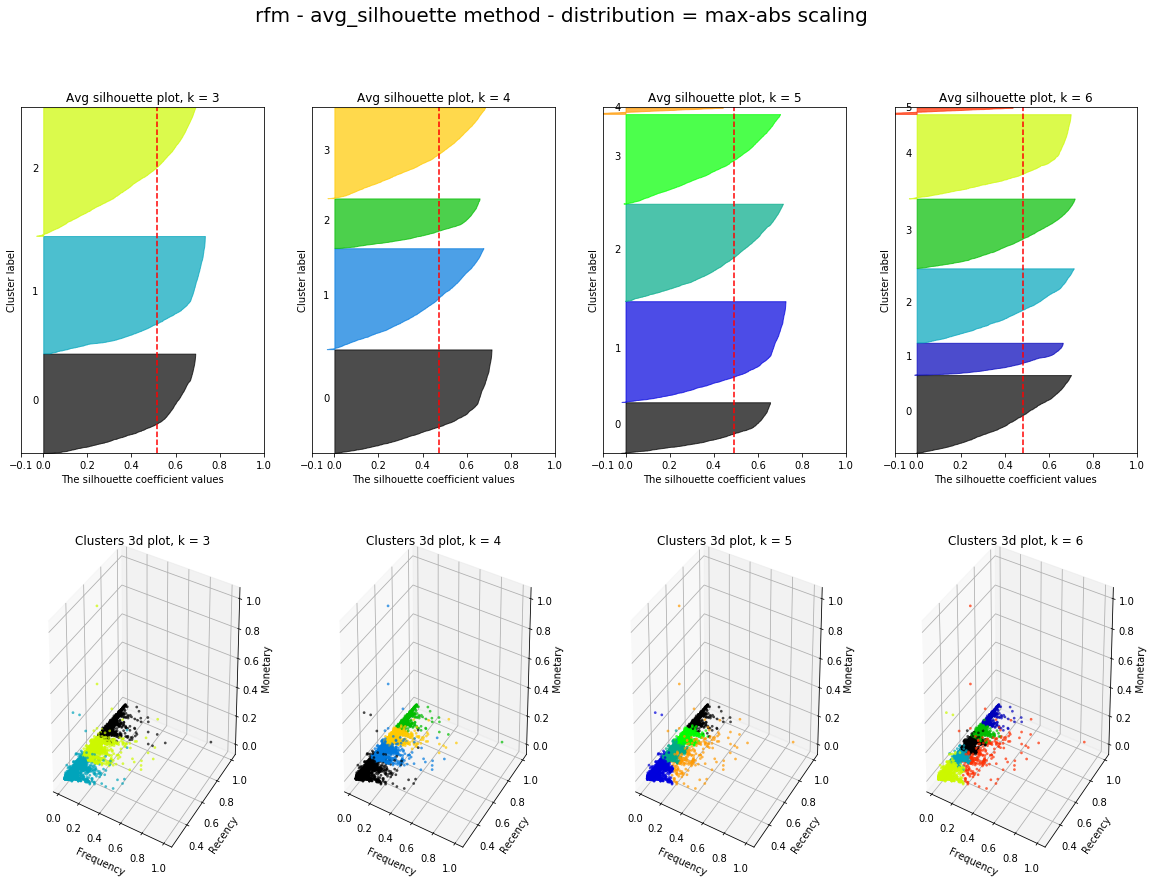

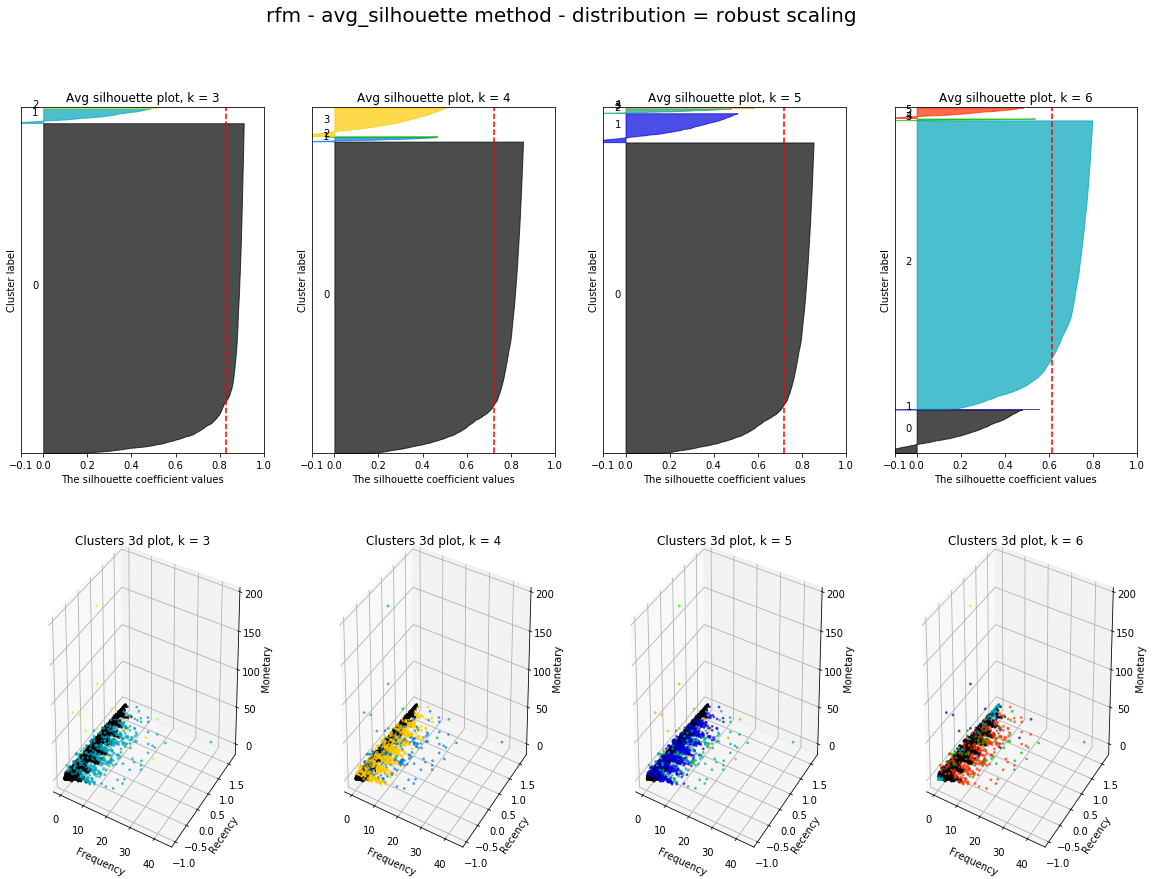

In [300]:
res_to_plot = plot_avg_silhouette_method(distributions, "rfm", a=3, b=6+1)

##### Result:
    * first let us also plot all coefficients in one graph

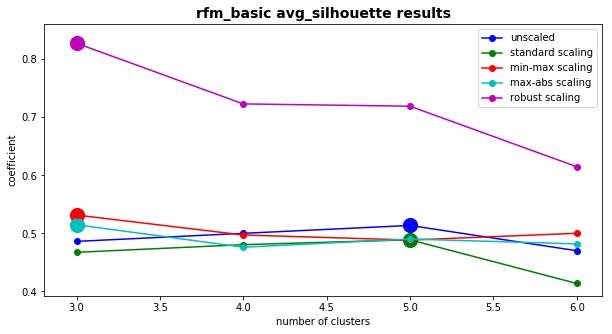

In [302]:
i = 1
plt.figure(figsize=(10,5))       # set dimensions of the figure
colors = ['ob-', 'og-', 'or-', 'oc-', 'om-', 'ok-']
for res in res_to_plot.values():
    x,y = res
    clr = colors[i-1]
    plt.plot(x,y, clr)
    plt.scatter(y.index(max(y))+min(x), max(y), s=200, c=clr[1:2])
    plt.xlabel('number of clusters')
    plt.ylabel('coefficient')
    plt.legend(res_to_plot)
    i +=1
    plt.title("rfm_basic avg_silhouette results", fontsize=14, fontweight='bold')
plt.show()

##### Result (...continued):
* Ok we crealrly see that best results are given using robust scaler
    * that makes sense, because it is based on percentiles
    * therefore it properly scale those few crazy outliers
    * It also seems, that best number of clusters is k=3
    * Second pick would be k = 5
    
* from plotted clusters we see, that robust scaled data don't split clusters in "Recency" axis
* That is not a problem, because it would let Us choose clusters across this axis
    * I mean like: "Give me some all-star customers who bougt some goods at our page no more that one month ago..."

# 1.3 Gap Statistic
* also pretty straightforward method
* we calculate variance for various number of clusters  as var_k
* we also calculate variance of B random bootstraps for same various number of clusters as var_B_k
    * usually B = 500 is used, which gives quite precise results
* next we compute gap statisitc for each cluster count as 
    * gap(k) =  avg. from all log(var_B_k) - log(var_k)
* for robust version ve compute also
    * next we compute standart deviation sd(k) of all B subsets
    * and finally define s_k = sd(k) x sqrt(1 + 1/b)
    * #of cluster will be min{ gap(k) >= gap(k+1_ - s_(k+1)}

In [376]:
from math import sqrt

def gap_statistic_method(data, a=3, b=7):
    results_to_plot = {}
    
    for distrib in data:
        title, X = distrib
        
        B = 500
        gaps = []
        results_x = []
        results_y = []
        results_y_sk = []
        
        for clusters in range(a, b):
            km = KMeans(clusters)
            km.fit(X)
            variance = km.inertia_
            #variance = np.average(pow(np.min(cdist(X, km.cluster_centers_, 'euclidean'), axis=1), 2))
            
            sample_variances = []
            for i in range(B):
                
                # (b - a) * random_sample() + a
                ba_0 = X[:,0].max() - X[:,0].min()
                a_0 =  X[:,0].min()
                ba_1 = X[:,1].max() - X[:,1].min()
                a_1 =  X[:,1].min()
                ba_2 = X[:,2].max() - X[:,2].min()
                a_2 =  X[:,2].min()
            
                sample = np.random.random_sample(size=X.shape)
                sample[:,0] = ba_0*sample[:,0] + a_0
                sample[:,1] = ba_1*sample[:,1] + a_1
                sample[:,2] = ba_2*sample[:,2] + a_2
                
                km = KMeans(clusters)
                km.fit(sample)
                sample_var = km.inertia_
                #sample_var = np.average(pow(np.min(cdist(sample, km.cluster_centers_, 'euclidean'), axis=1), 2))
                sample_variances.append(sample_var)

            # gap statistic
            w =  np.mean(np.log(sample_variances))
            gap = w - np.log(variance)
            sd = sqrt(  np.mean( pow(( np.log(sample_variances) - w), 2)  )   )
            sk = sd*sqrt(1+1/B)
            results_x.append(clusters)
            results_y.append(gap)
            results_y_sk.append(gap-sk)
            
        results_to_plot[title] = (results_x, results_y, results_y_sk)

    return results_to_plot
    

In [219]:
res_to_plot_gap_stat = gap_statistic_method(distributions)

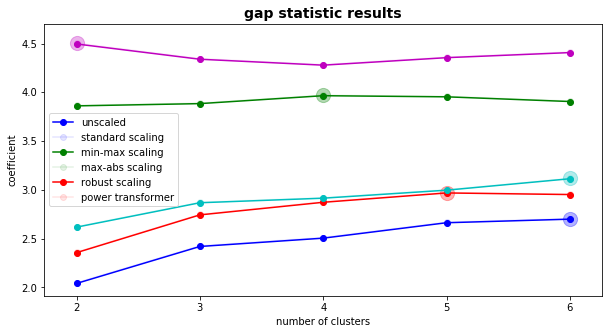

In [292]:
i = 1
plt.figure(figsize=(10,5))       # set dimensions of the figure
colors = ['ob-', 'og-', 'or-', 'oc-', 'om-', 'ok-']
for res in res_to_plot_gap_stat.values():
    x,y, y_sk = res
    clr = colors[i-1]
    plt.plot(x,y_sk, clr)
    plt.plot(x,y, clr,  alpha=0.1)
    
    plt.scatter(y.index(max(y))+min(x), max(y), s=200, c=clr[1:2], alpha=0.3)
    plt.xlabel('number of clusters')
    plt.ylabel('coefficient')
    plt.legend(res_to_plot)
    i +=1
    plt.title("gap statistic results", fontsize=14, fontweight='bold')
plt.show()

##### Result:
* They differ a bit from previous methods I'm not sure if I didn't do something wrong

# 2. rfm_modified

* Recency = "max{# M od posledního nákupu , 1}"
* Frequency = "max{#nakupu za poslednich 12 mes, 1}"
* Monetary = "max{nakupy}"

* I'm a bit confused right now ... max{ #nakupu v poslednich 12M ,1 }
    * that would mean all of them get 1
    * solution: I'l assume that today is 2015-12-19

In [275]:
df.Date.max()

Timestamp('2015-12-19 00:00:00')

In [253]:
df.Date =  pd.to_datetime(df.Date,infer_datetime_format=False)

In [280]:
df_agg_2 = df.groupby('Customer ID').apply(lambda x: pd.Series({ 'Recency': x.Date.max(),'Frequency': ((x.Date.max() - x.Date) <= np.timedelta64(12,'M')).sum(),'Monetary': x.Subtotal.max()}))
df_agg_2.Recency =  (np.datetime64('2015-12-19') - df_agg_2.Recency) / np.timedelta64(1,'M')
df_agg_2.Recency = np.where(df_agg_2.Recency < 1, 1, df_agg_2.Recency)
df_agg_2.Recency =  df_agg_2.Recency.astype('int64')
rfm_modifed = df_agg_2[['Recency', 'Frequency', 'Monetary']].copy()

* and plot the result

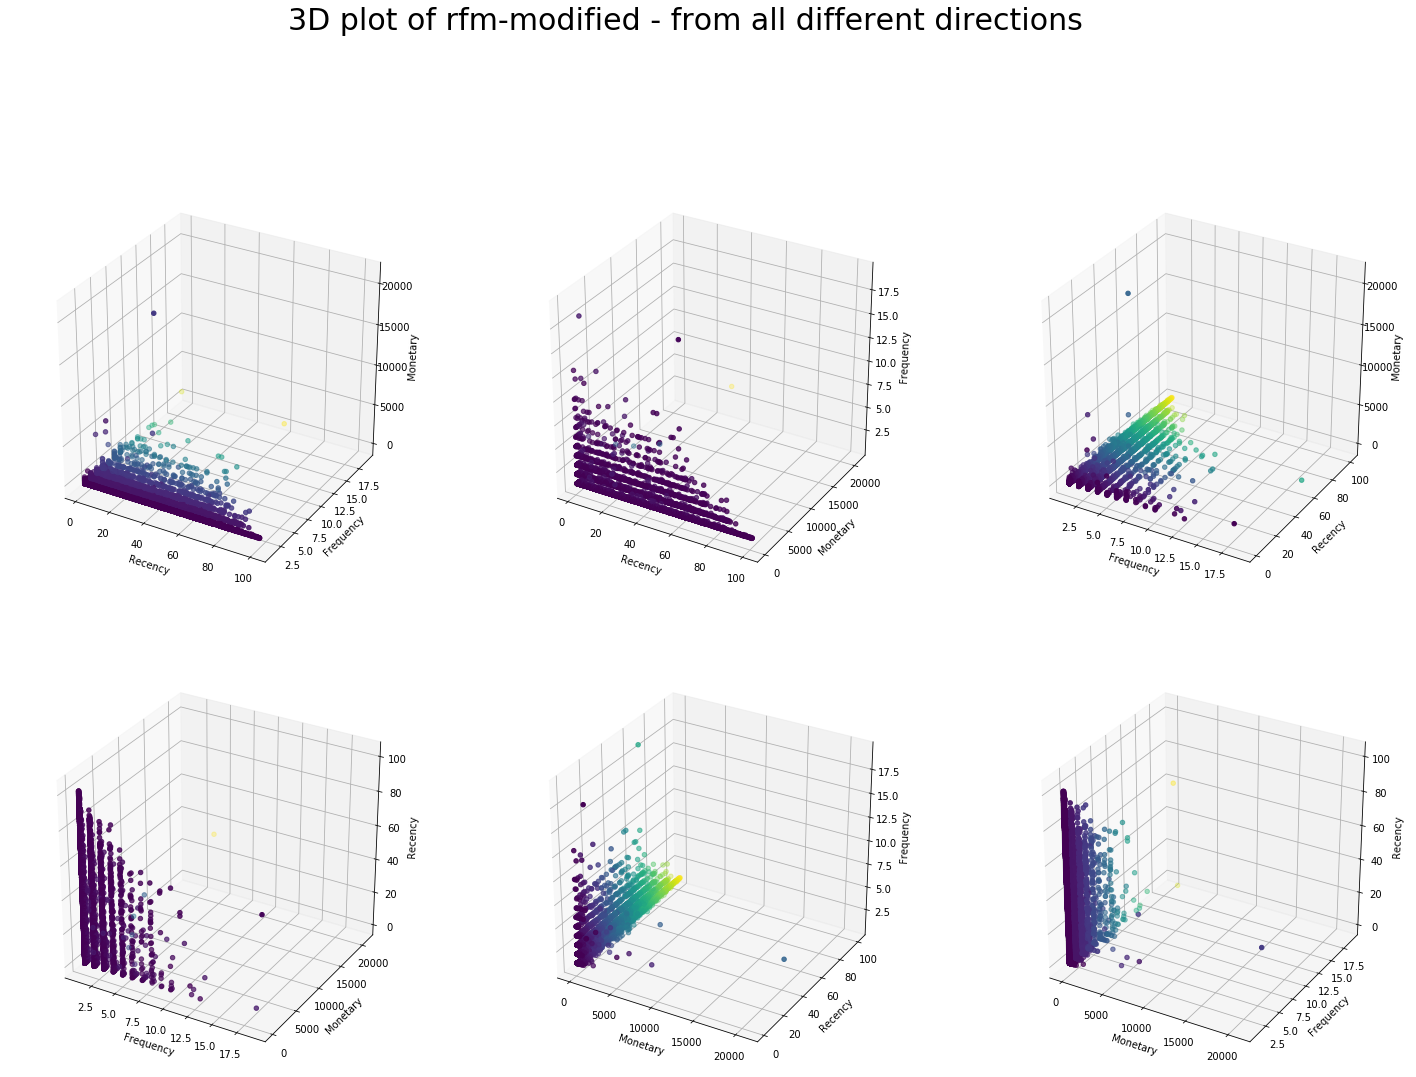

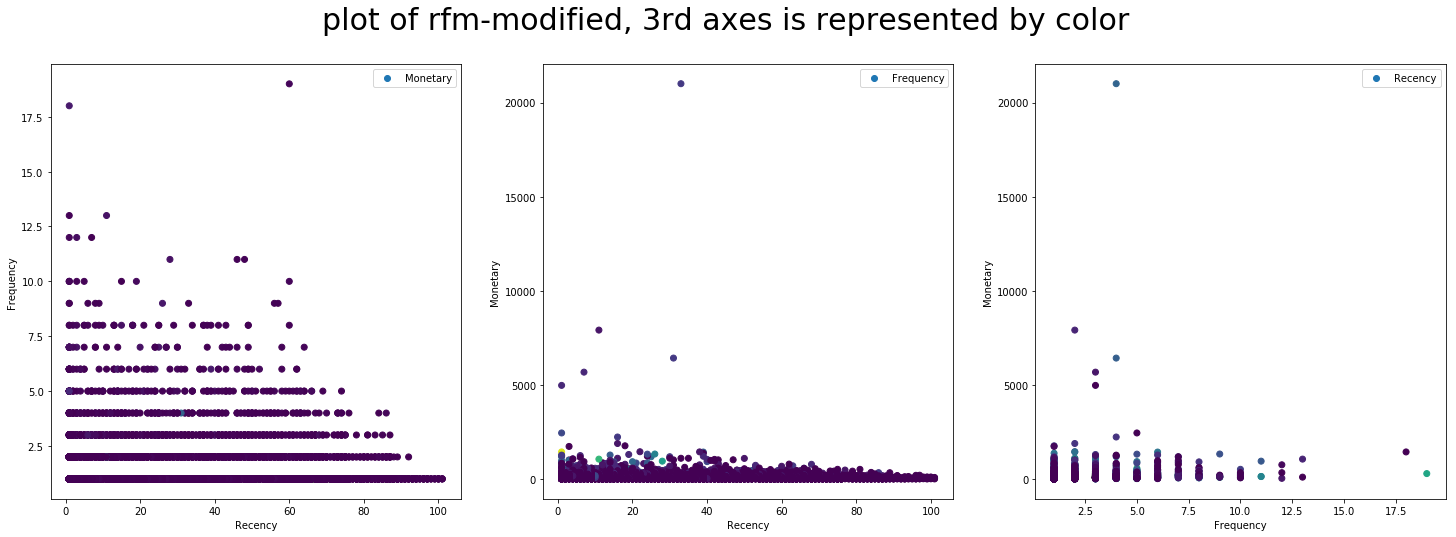

In [340]:
# make 3d and 2d plots
plot_it_3d(rfm_modifed, 'rfm-modified')
plot_it_2d(rfm_modifed, 'rfm-modified')

##### Result:
* we see that data has much less noise
* I really want do delete those outliers !!!! :-D

## 2.1 elbow method

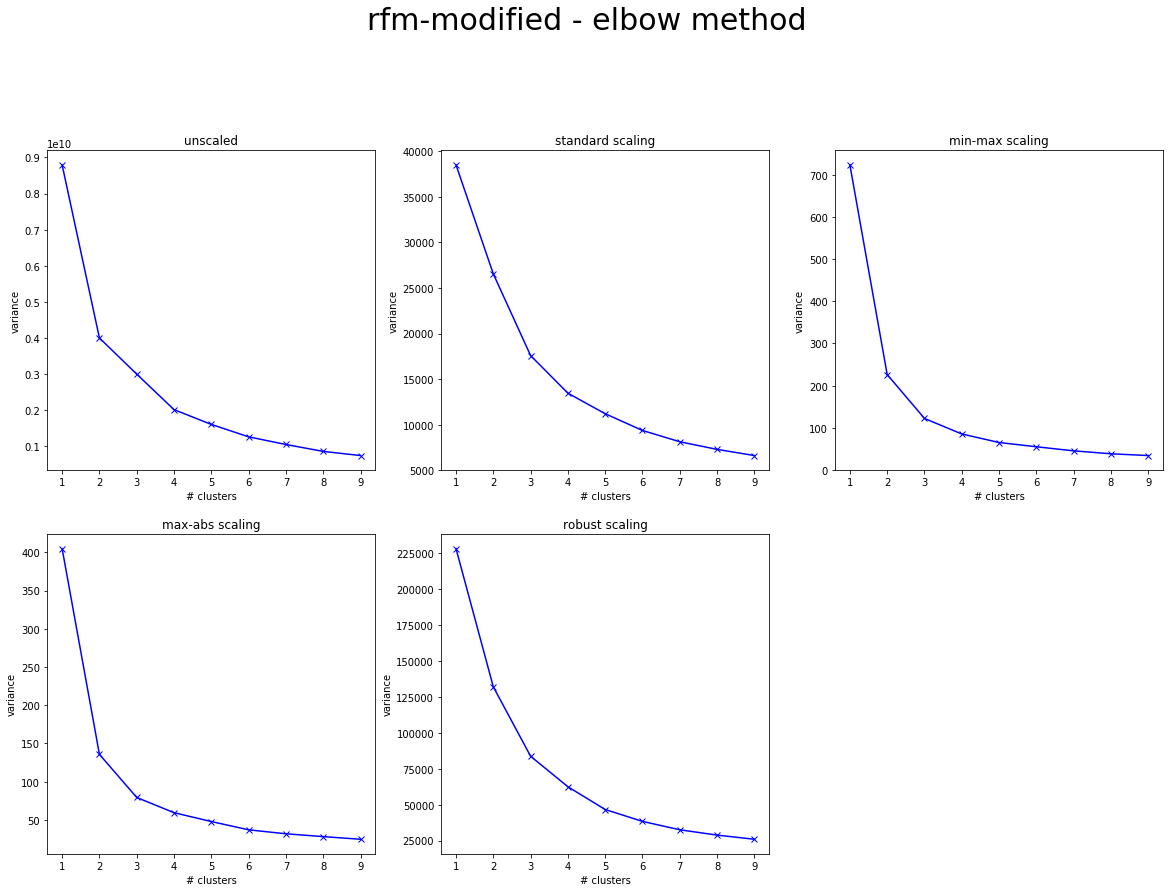

In [295]:
distributions_modif = scale_data(rfm_modifed)    
plot_elbow_method(distributions_modif, "rfm-modified - elbow method")

##### Result:
* We can see that optimal number of cluster will bee between 2 and 4

## 2.2 silhouette method

* we'll limit range of number of clusters based on elbow method results 

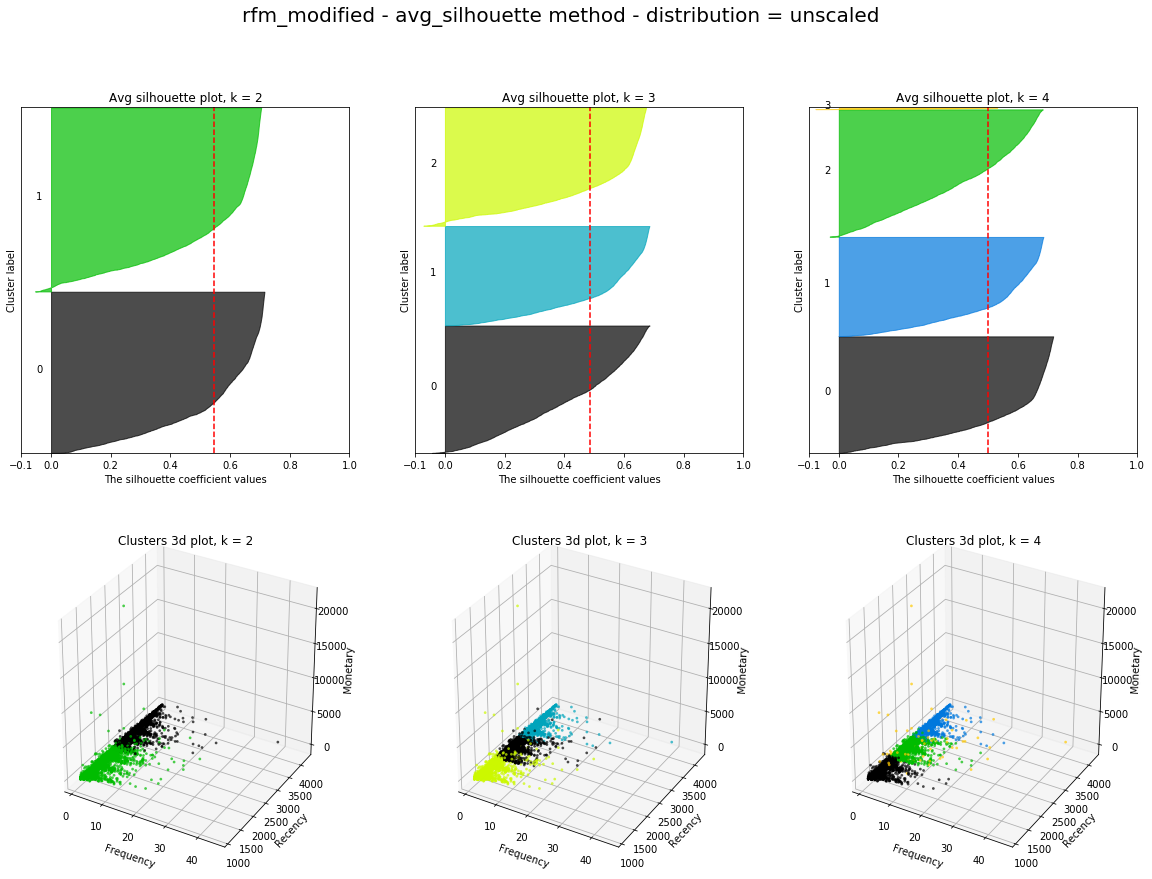

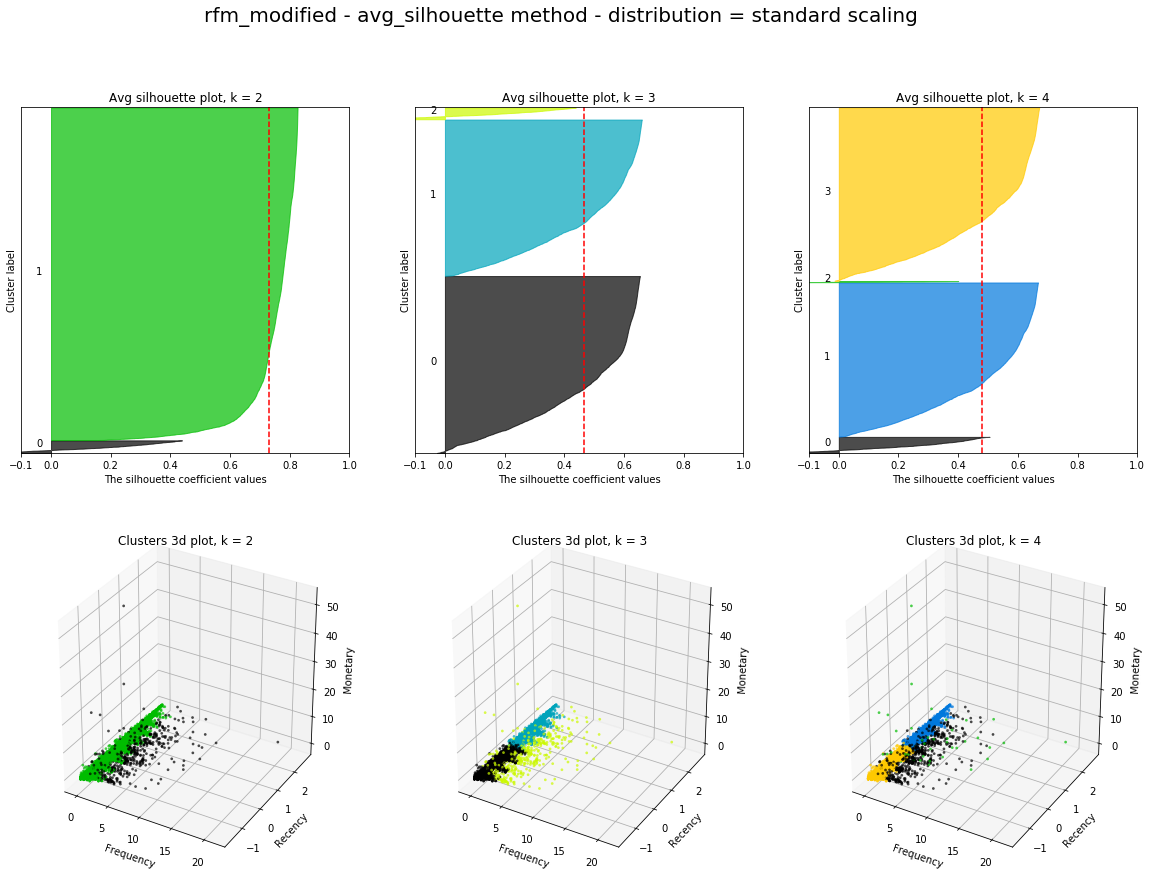

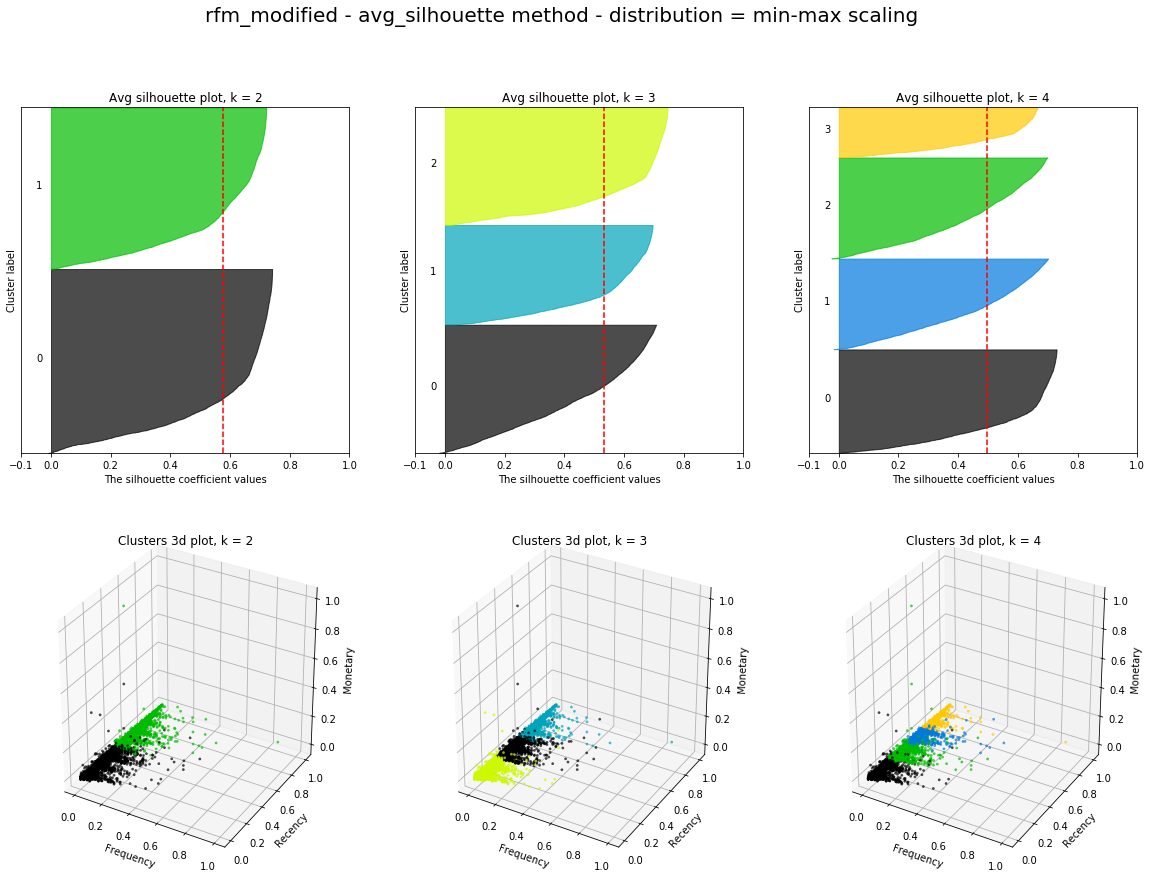

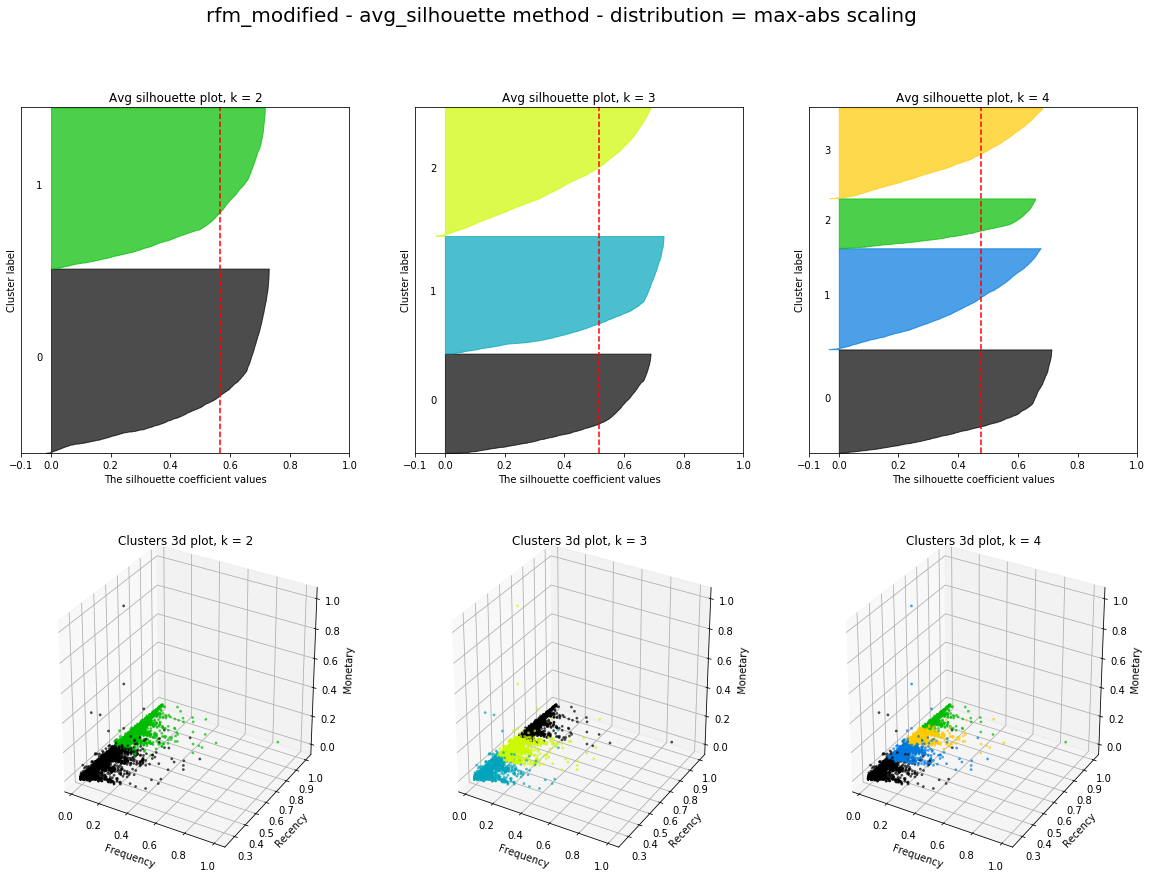

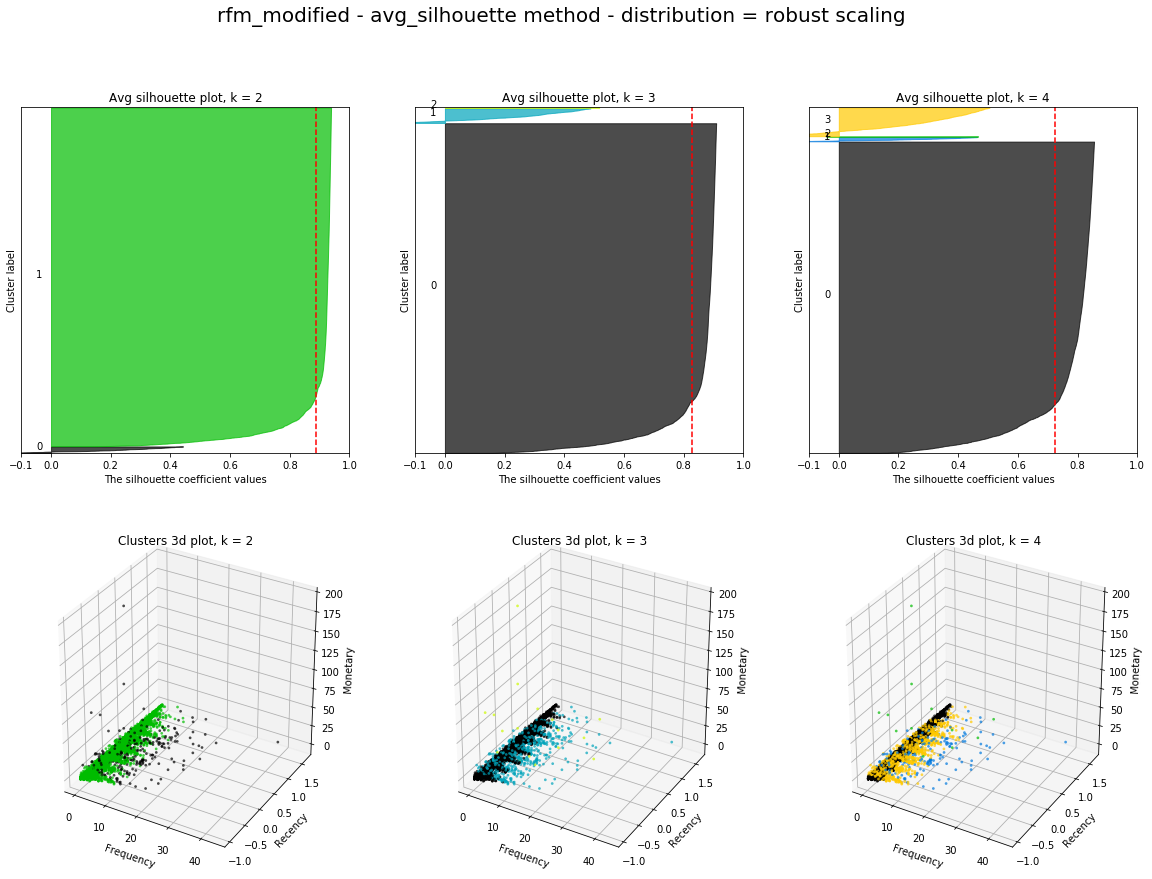

In [301]:
res_to_plot_modif = plot_avg_silhouette_method(distributions_modif, "rfm_modified", a=2, b=4+1)

* And also plot the final results

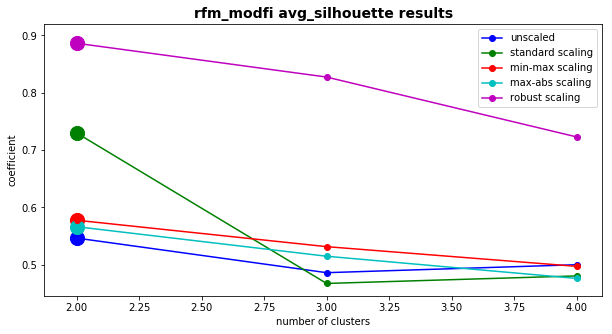

In [303]:
i = 1
plt.figure(figsize=(10,5))       # set dimensions of the figure
colors = ['ob-', 'og-', 'or-', 'oc-', 'om-', 'ok-']
for res in res_to_plot_modif.values():
    x,y = res
    clr = colors[i-1]
    plt.plot(x,y, clr)
    plt.scatter(y.index(max(y))+min(x), max(y), s=200, c=clr[1:2])
    plt.xlabel('number of clusters')
    plt.ylabel('coefficient')
    plt.legend(res_to_plot)
    i +=1
    plt.title("rfm_modfi avg_silhouette results", fontsize=14, fontweight='bold')
plt.show()

##### Result:

* Robust scaling again perform the best
* I guess it's again due to good way of handling outliers
* Some clusters are very very small. I belive those are outliers, which makes me want to delete them even more!

## 2.3 Ok I made my mind - I'll remove some outliers manually
* It is clearly visible that some guys acted crazy when they were shopping
* Maybe we should give them some special treatment (golden card etc...)
    * but in our case we'll delete them

In [320]:
rfm_modifed.describe()

Recency     Frequency      Monetary
count  12829.000000  12829.000000  12829.000000
mean      35.755554      1.404708     95.009815
std       23.835912      1.008104    245.934027
min        1.000000      1.000000      1.180000
25%       14.000000      1.000000     30.510000
50%       34.000000      1.000000     56.670000
75%       55.000000      1.000000    109.040000
max      101.000000     19.000000  21001.050000

In [365]:
rfm_modifed.quantile(0.995)

Recency       92.0000
Frequency      7.0000
Monetary     800.0112
Name: 0.995, dtype: float64

In [366]:
rfm_modifed_2 = rfm_modifed[rfm_modifed.Monetary < 801].copy()
rfm_modifed_2 = rfm_modifed_2[rfm_modifed_2.Frequency <= 7]
rfm_modifed_2.describe()

Recency     Frequency      Monetary
count  12712.000000  12712.000000  12712.000000
mean      35.897970      1.360997     86.014221
std       23.843045      0.827141     91.871159
min        1.000000      1.000000      1.180000
25%       15.000000      1.000000     30.400000
50%       35.000000      1.000000     56.075000
75%       55.000000      1.000000    107.127500
max      101.000000      7.000000    800.770000

* lets visualise it

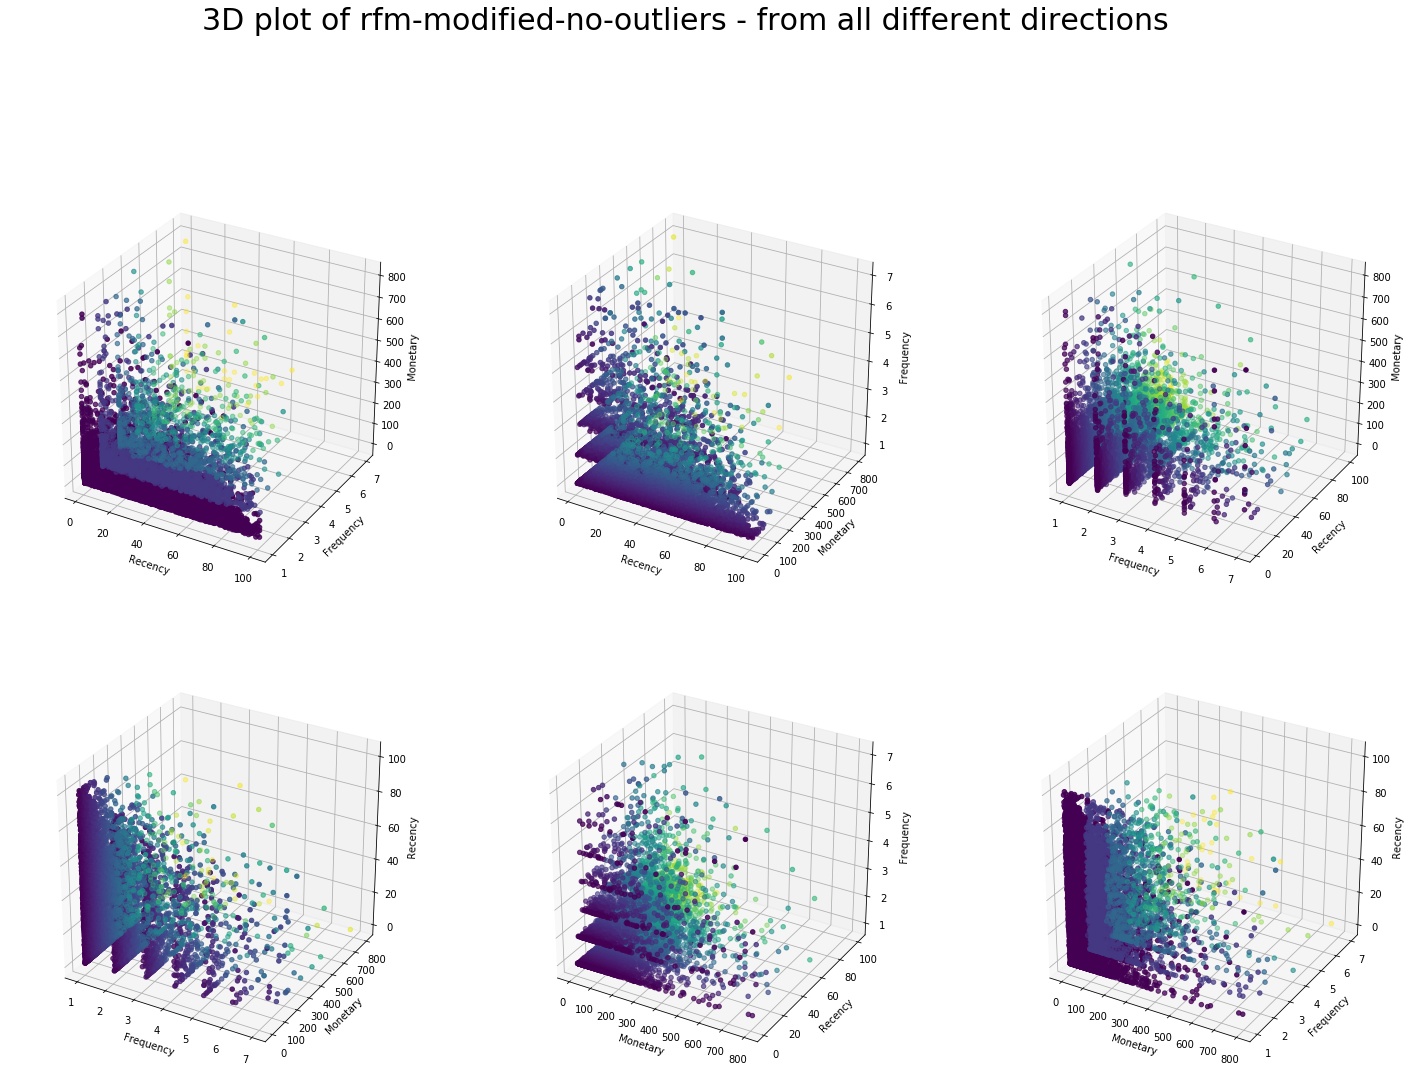

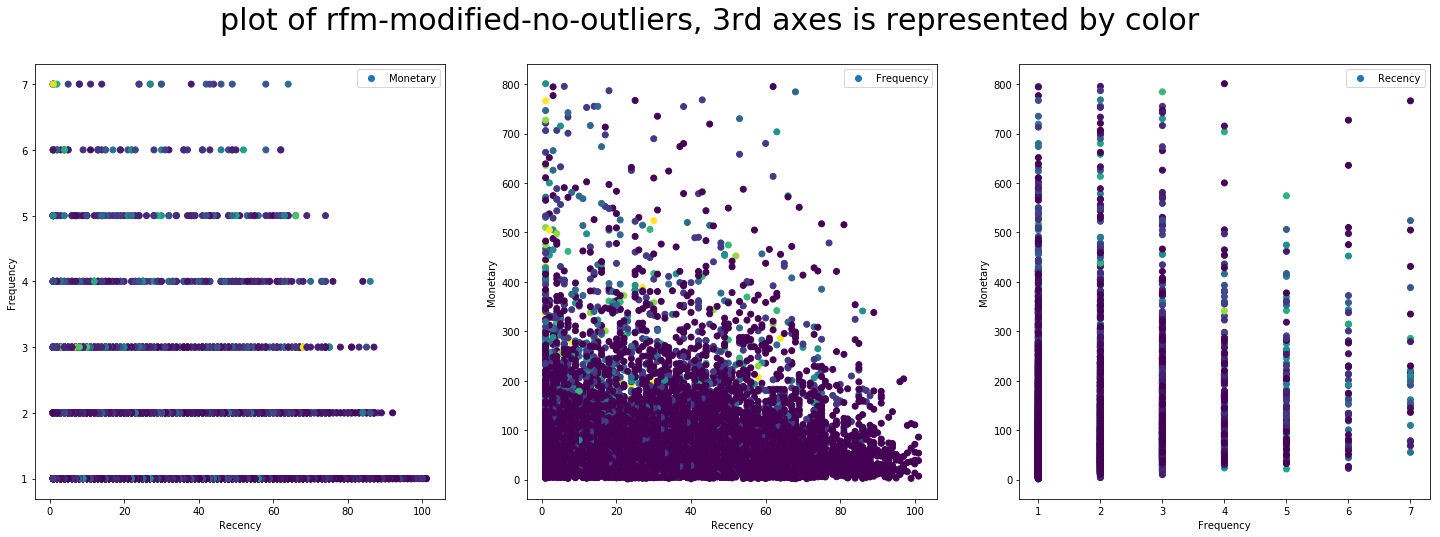

In [367]:
plot_it_3d(rfm_modifed_2, 'rfm-modified-no-outliers')
plot_it_2d(rfm_modifed_2, 'rfm-modified-no-outliers')

* wow
* Ok let's try to repeat above methods

### 2.3.1 modifed, no outlier, elbow 

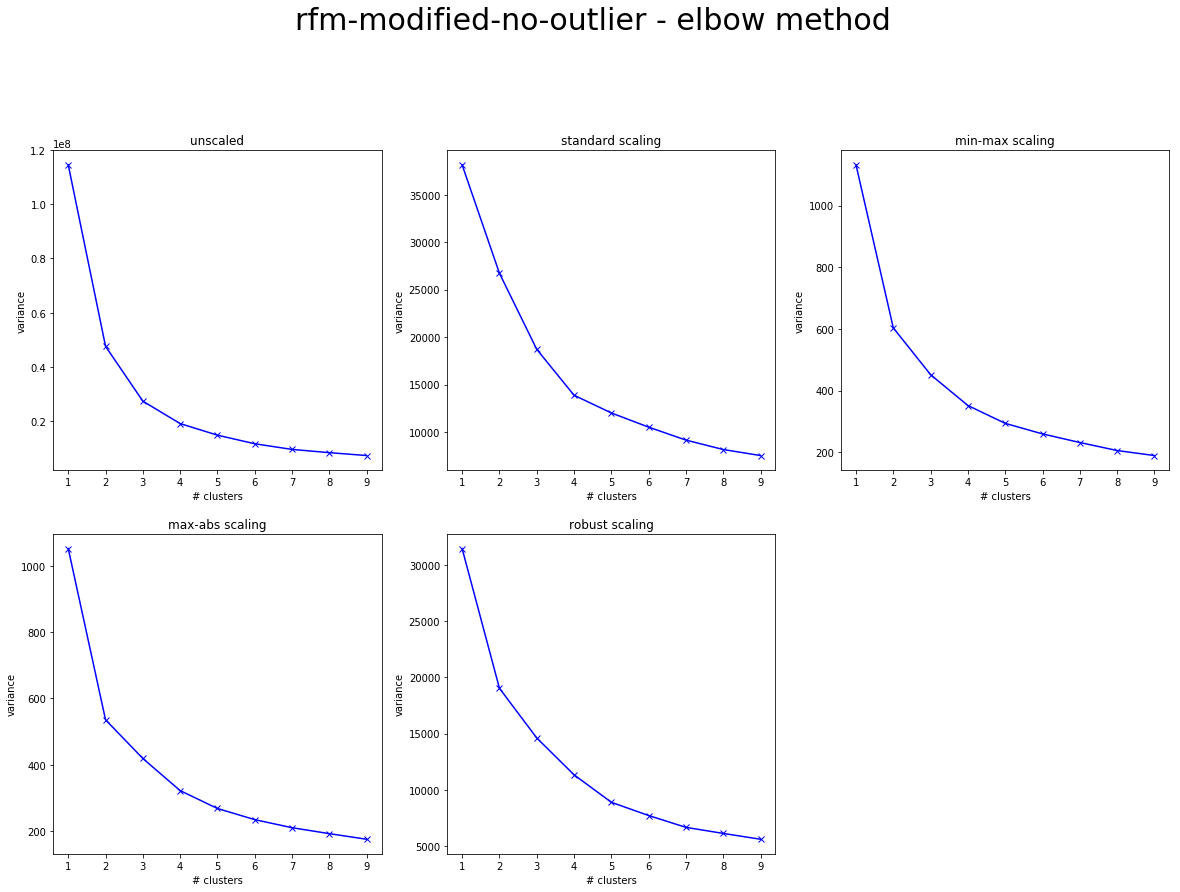

In [372]:
distributions_modif_2 = scale_data(rfm_modifed_2)    
plot_elbow_method(distributions_modif_2, "rfm-modified-no-outlier - elbow method")

### 2.3.2 modifed, no outlier, silhouette 


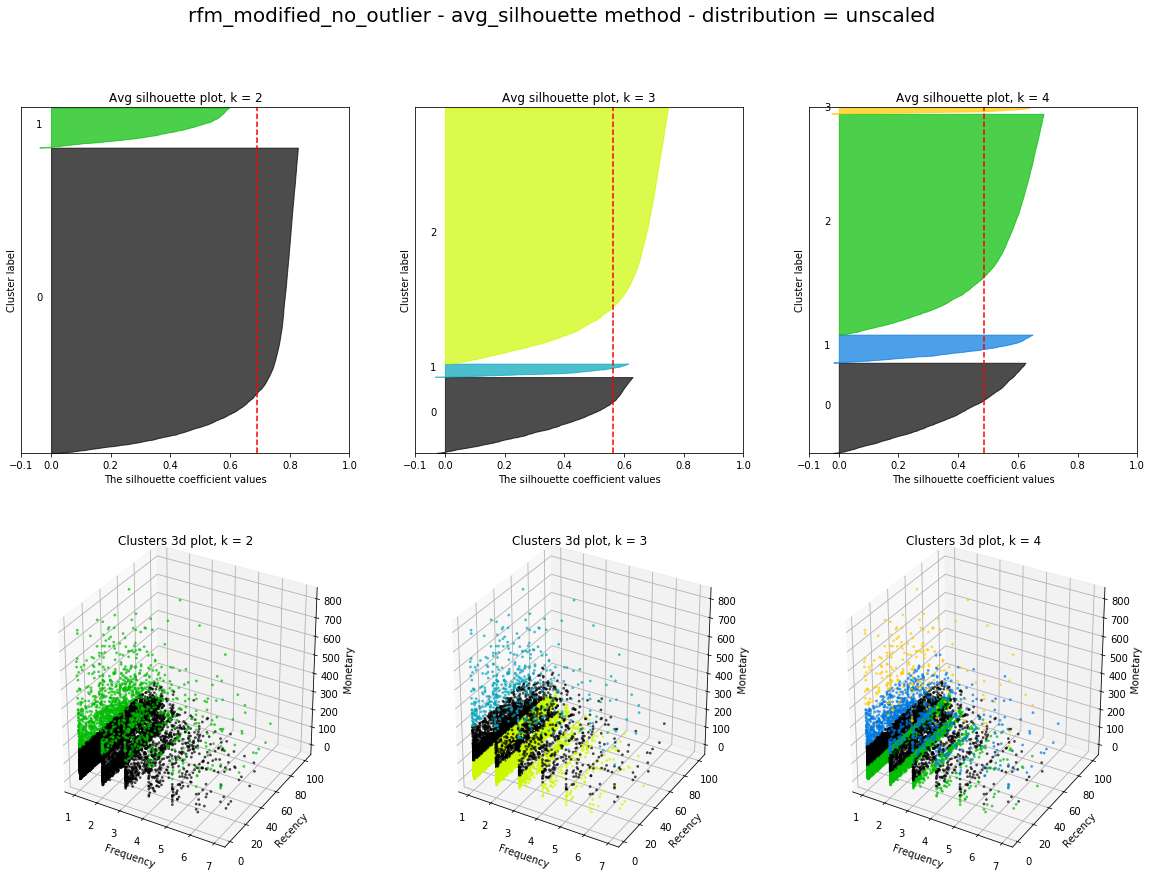

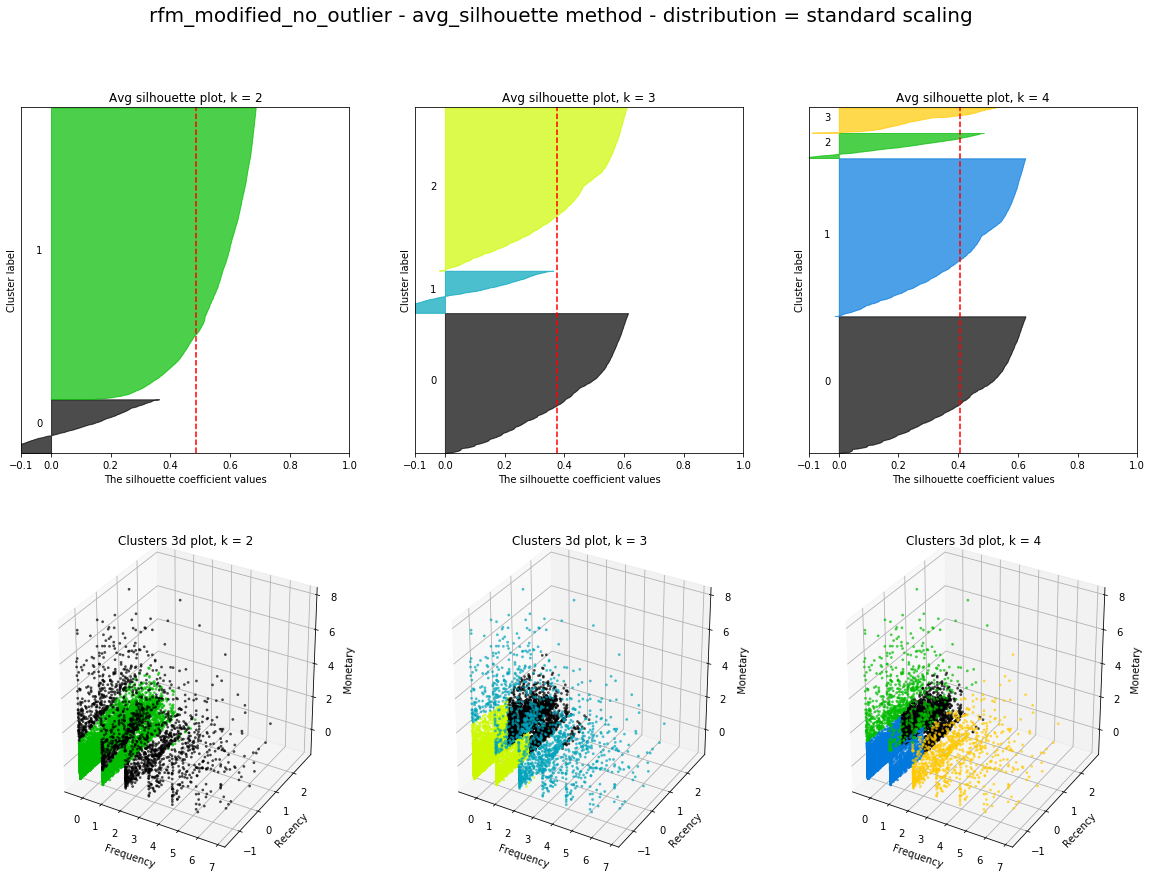

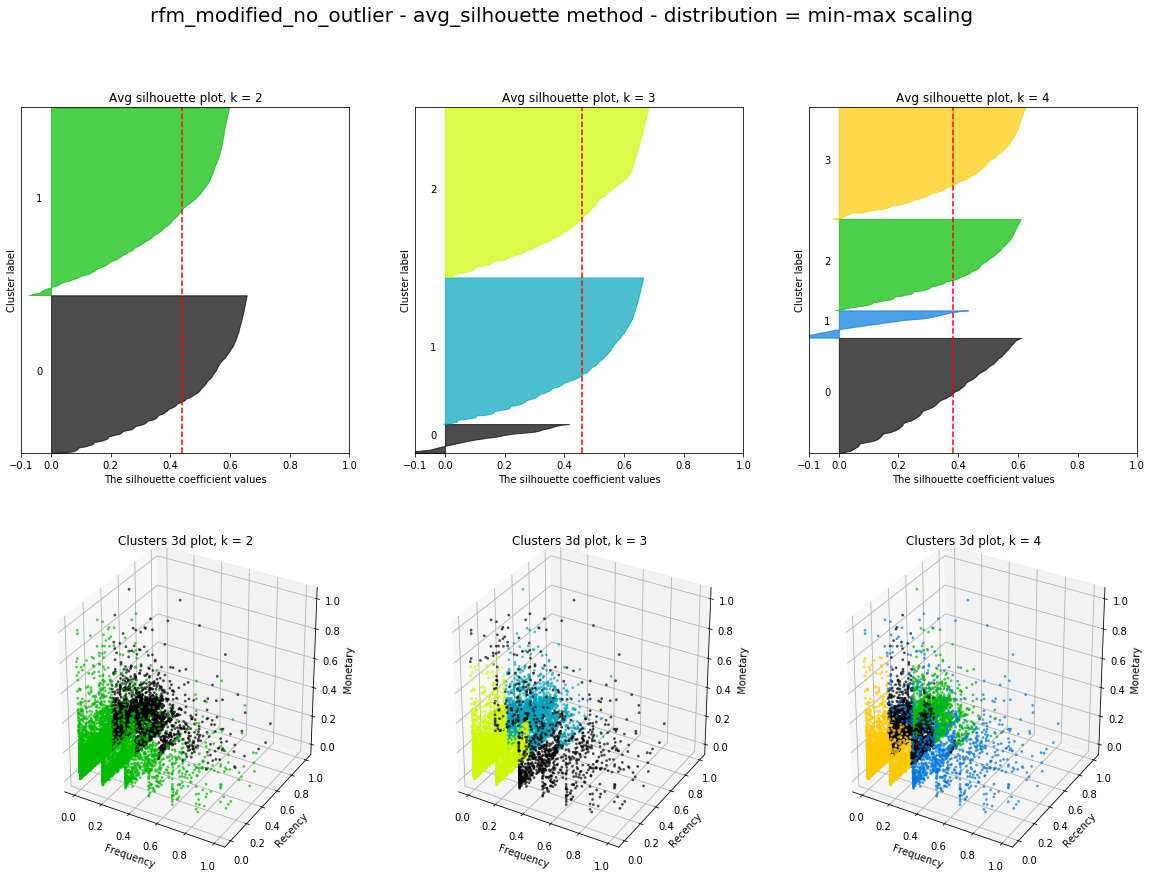

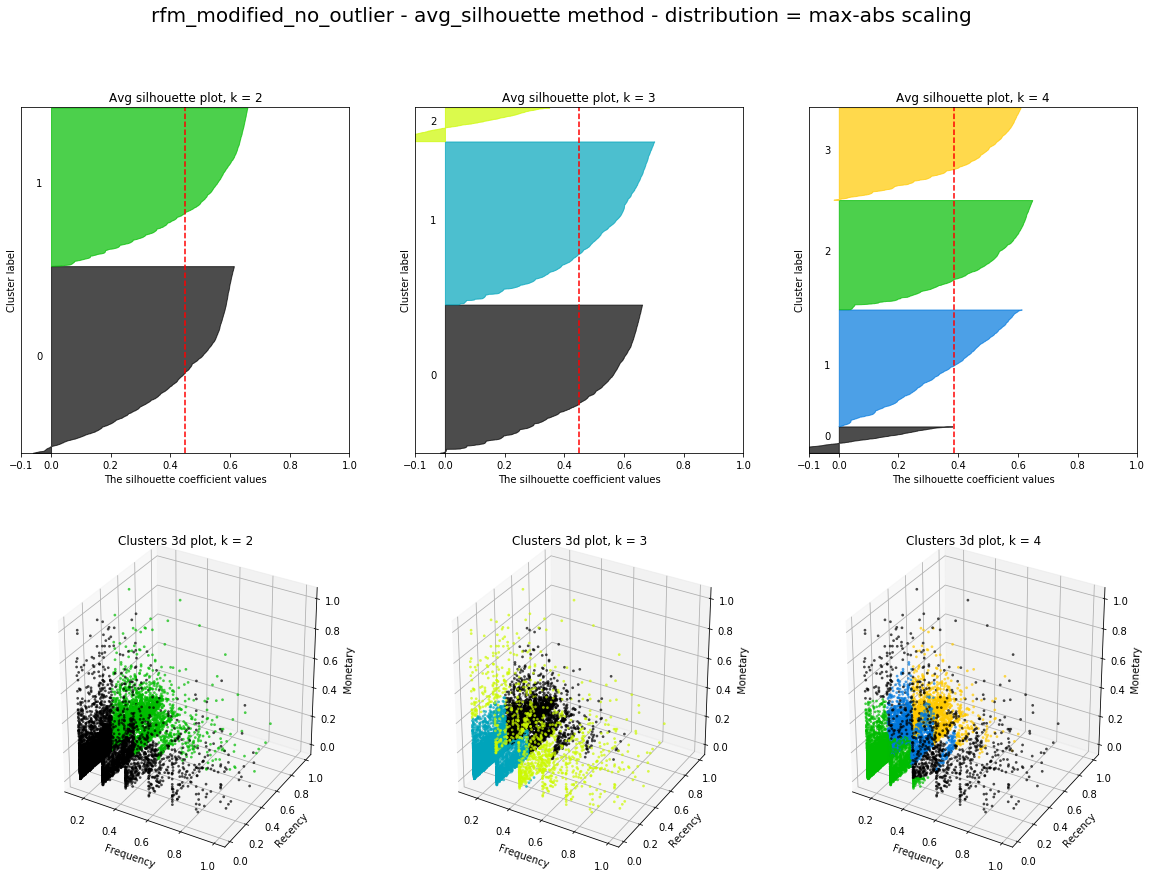

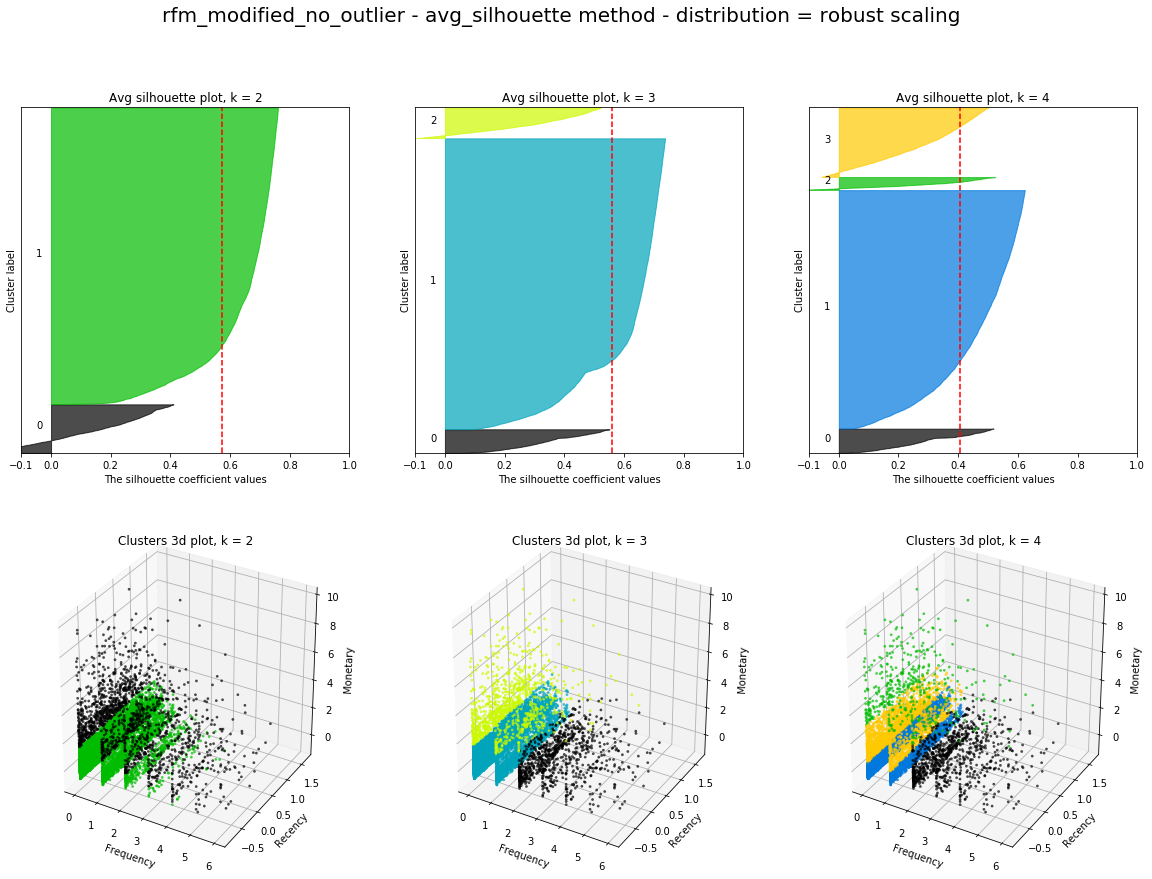

In [373]:
res_to_plot_modif_2 = plot_avg_silhouette_method(distributions_modif_2, "rfm_modified_no_outlier", a=2, b=4+1)

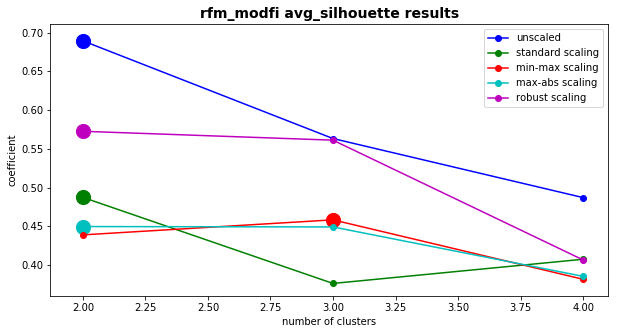

In [374]:
i = 1
plt.figure(figsize=(10,5))       # set dimensions of the figure
colors = ['ob-', 'og-', 'or-', 'oc-', 'om-', 'ok-']
for res in res_to_plot_modif_2.values():
    x,y = res
    clr = colors[i-1]
    plt.plot(x,y, clr)
    plt.scatter(y.index(max(y))+min(x), max(y), s=200, c=clr[1:2])
    plt.xlabel('number of clusters')
    plt.ylabel('coefficient')
    plt.legend(res_to_plot)
    i +=1
    plt.title("rfm_modfi avg_silhouette results", fontsize=14, fontweight='bold')
plt.show()

### 2.3.2 modifed, no outlier, gap_statistic

In [377]:
res_to_plot_gap_stat_2 = gap_statistic_method(distributions_modif_2, a=2, b=5+1)

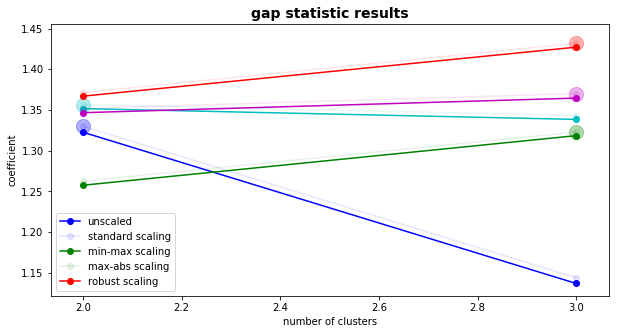

In [378]:
i = 1
plt.figure(figsize=(10,5))       # set dimensions of the figure
colors = ['ob-', 'og-', 'or-', 'oc-', 'om-', 'ok-']
for res in res_to_plot_gap_stat_2.values():
    x,y, y_sk = res
    clr = colors[i-1]
    plt.plot(x,y_sk, clr)
    plt.plot(x,y, clr,  alpha=0.1)
    
    plt.scatter(y.index(max(y))+min(x), max(y), s=200, c=clr[1:2], alpha=0.3)
    plt.xlabel('number of clusters')
    plt.ylabel('coefficient')
    plt.legend(res_to_plot)
    i +=1
    plt.title("gap statistic results", fontsize=14, fontweight='bold')
plt.show()

# 3. Results
- Interpretujte jednotlivé shluky. Použijte získané shluky k odlišení
    -  "superstar" zákazníků (vysoká monetary, vysoká frequency a nízká recency) 
    - nezajímavých  zákazníků (vysoká recency, nízká frequency, nízká monetary).

* We've used multiple of different methods to determine suitable number of clusters
* We can see from the graphs, that modification of the data heleped a lot to clear noise
* We can also see, that normalisation of the data is very usefull, usually best resuts were given by RobustScaler, which works with percentiles, so it handles outliers very well
* Last but not least we tried to delete some outliers (superstar outliers) in sake of better cluster model
    * Bigest reason was, that some clusters were extremely small, just covering few outliers
* That helped a lot also

In [385]:
final_data = RobustScaler(quantile_range=(25, 75)).fit_transform(rfm_modifed_2)

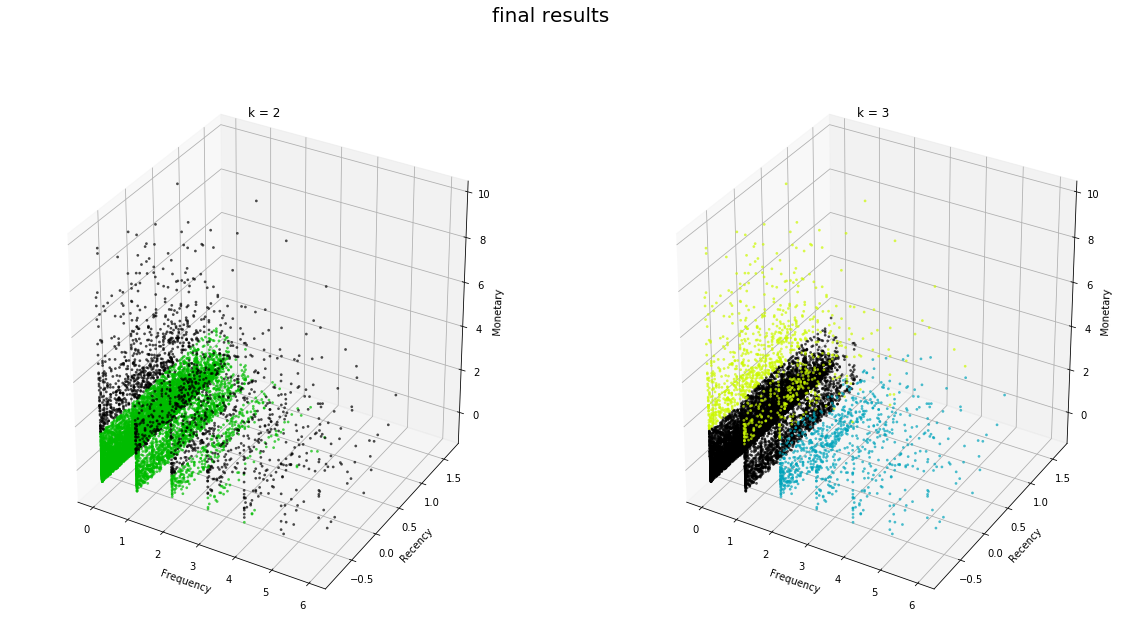

In [384]:
# figure
fig = plt.figure(figsize=(20,10))
fig.suptitle("final results", fontsize=20)
ax1 = plt.subplot(1,2,1, projection='3d')
ax2 = fig.add_subplot(1, 2,2, projection='3d')


# first one
n_clusters = 2
km = KMeans(n_clusters=n_clusters)
cluster_labels = km.fit_predict(final_data)

# Visualise clusters
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
ax1.scatter(final_data[:, 1], final_data[:, 0],final_data[:, 2] , marker='.', s=30, lw=0, alpha=0.7,c=colors, edgecolor='k', )
ax1.set_title("k = {}".format(n_clusters))
ax1.set_xlabel('Frequency')
ax1.set_ylabel('Recency')
ax1.set_zlabel('Monetary')


# second one
n_clusters = 3
km = KMeans(n_clusters=n_clusters)
cluster_labels = km.fit_predict(final_data)

# Visualise clusters
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
ax2.scatter(final_data[:, 1], final_data[:, 0],final_data[:, 2] , marker='.', s=30, lw=0, alpha=0.7,c=colors, edgecolor='k', )
ax2.set_title("k = {}".format(n_clusters))
ax2.set_xlabel('Frequency')
ax2.set_ylabel('Recency')
ax2.set_zlabel('Monetary')
plt.show()

##### For two clusters:
* **Superstarts**
    * if we'll use data with removed outliers, then, as I mentioned before, outliers are autamatically superstars
    * Moreover Superstars are also all people from cluster whis is visualised in black color
    * those people spent significant amount of the money and also shopped frequently
* **others**
    * cluster labeled as 1 represents people who are not interesting

##### For three clusters:
* **Superstars**
    * We can see that there are two types of Superstars. Those who shop more often + those who spent really a lot of money
* **others**
    * Are much more visible here. Represented by black color, that is the majority of the customers, who shopped only once o twice.. and never spent bigger sums of money
    
    
##### Recency:    
* When we talk about recency, we can clearly see, that our clusters more or less goes through all recency values
* Thats not a bad thing, due to that, we can simply slice our clusters, to focus on customers from specific period
    * for inststance: send newsletter to superstars who were not seem for couple of months 

### E-N-D